<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#KFIR" data-toc-modified-id="KFIR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>KFIR</a></span></li><li><span><a href="#SETUP:-DEPENDENCIES-AND-CREDENTIALS" data-toc-modified-id="SETUP:-DEPENDENCIES-AND-CREDENTIALS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SETUP: DEPENDENCIES AND CREDENTIALS</a></span><ul class="toc-item"><li><span><a href="#Working-Directory" data-toc-modified-id="Working-Directory-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Working Directory</a></span></li><li><span><a href="#Initialize-General-Packages-and-Set-Notebook-wide-Parameters" data-toc-modified-id="Initialize-General-Packages-and-Set-Notebook-wide-Parameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Initialize General Packages and Set Notebook-wide Parameters</a></span></li><li><span><a href="#Initialize-Plotly" data-toc-modified-id="Initialize-Plotly-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Initialize Plotly</a></span><ul class="toc-item"><li><span><a href="#Online-Plotly" data-toc-modified-id="Online-Plotly-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Online Plotly</a></span></li><li><span><a href="#Offline-Plotly" data-toc-modified-id="Offline-Plotly-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Offline Plotly</a></span></li></ul></li><li><span><a href="#Initialize-Retriever:-Gastrodon_Query" data-toc-modified-id="Initialize-Retriever:-Gastrodon_Query-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Initialize Retriever: Gastrodon_Query</a></span><ul class="toc-item"><li><span><a href="#Initialize-eCulture-Query" data-toc-modified-id="Initialize-eCulture-Query-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Initialize eCulture Query</a></span></li><li><span><a href="#Define-Prefixes" data-toc-modified-id="Define-Prefixes-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Define Prefixes</a></span></li><li><span><a href="#Set-Up-Endpoint" data-toc-modified-id="Set-Up-Endpoint-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Set Up Endpoint</a></span></li></ul></li></ul></li><li><span><a href="#QUERIES" data-toc-modified-id="QUERIES-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>QUERIES</a></span><ul class="toc-item"><li><span><a href="#Statistics-of-SPARQL-Database" data-toc-modified-id="Statistics-of-SPARQL-Database-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Statistics of SPARQL Database</a></span><ul class="toc-item"><li><span><a href="#Variable-Mappings" data-toc-modified-id="Variable-Mappings-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Variable Mappings</a></span></li><li><span><a href="#Unique-Value-Occurrence-Counts-for-All-Variables" data-toc-modified-id="Unique-Value-Occurrence-Counts-for-All-Variables-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Unique Value Occurrence Counts for All Variables</a></span><ul class="toc-item"><li><span><a href="#Getting-Unique-Counts-with-a-Generic-Query" data-toc-modified-id="Getting-Unique-Counts-with-a-Generic-Query-3.1.2.1"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>Getting Unique Counts with a Generic Query</a></span></li><li><span><a href="#Correcting-Unique-Counts-for-Complex-Structures" data-toc-modified-id="Correcting-Unique-Counts-for-Complex-Structures-3.1.2.2"><span class="toc-item-num">3.1.2.2&nbsp;&nbsp;</span>Correcting Unique Counts for Complex Structures</a></span><ul class="toc-item"><li><span><a href="#Correcting-annotation-counts" data-toc-modified-id="Correcting-annotation-counts-3.1.2.2.1"><span class="toc-item-num">3.1.2.2.1&nbsp;&nbsp;</span>Correcting <code>annotation</code> counts</a></span></li><li><span><a href="#Correcting-author-counts" data-toc-modified-id="Correcting-author-counts-3.1.2.2.2"><span class="toc-item-num">3.1.2.2.2&nbsp;&nbsp;</span>Correcting <code>author</code> counts</a></span></li><li><span><a href="#Getting-the-number-of-articles" data-toc-modified-id="Getting-the-number-of-articles-3.1.2.2.3"><span class="toc-item-num">3.1.2.2.3&nbsp;&nbsp;</span>Getting the number of articles</a></span></li></ul></li></ul></li><li><span><a href="#Cumulative-Value-Occurrence-Counts-for-All-Variables" data-toc-modified-id="Cumulative-Value-Occurrence-Counts-for-All-Variables-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Cumulative Value Occurrence Counts for All Variables</a></span><ul class="toc-item"><li><span><a href="#Getting-Cumulative-Counts-with-a-Generic-Query" data-toc-modified-id="Getting-Cumulative-Counts-with-a-Generic-Query-3.1.3.1"><span class="toc-item-num">3.1.3.1&nbsp;&nbsp;</span>Getting Cumulative Counts with a Generic Query</a></span></li><li><span><a href="#Correcting-Cumulative-Counts-for-Complex-Structures" data-toc-modified-id="Correcting-Cumulative-Counts-for-Complex-Structures-3.1.3.2"><span class="toc-item-num">3.1.3.2&nbsp;&nbsp;</span>Correcting Cumulative Counts for Complex Structures</a></span><ul class="toc-item"><li><span><a href="#Correcting-annotation-counts" data-toc-modified-id="Correcting-annotation-counts-3.1.3.2.1"><span class="toc-item-num">3.1.3.2.1&nbsp;&nbsp;</span>Correcting <code>annotation</code> counts</a></span></li><li><span><a href="#Correcting-author-counts" data-toc-modified-id="Correcting-author-counts-3.1.3.2.2"><span class="toc-item-num">3.1.3.2.2&nbsp;&nbsp;</span>Correcting <code>author</code> counts</a></span></li><li><span><a href="#Getting-the-number-of-articles" data-toc-modified-id="Getting-the-number-of-articles-3.1.3.2.3"><span class="toc-item-num">3.1.3.2.3&nbsp;&nbsp;</span>Getting the number of articles</a></span></li></ul></li></ul></li><li><span><a href="#Comparison-of-Unique-and-Cumulative-Variable-Occurrence-Counts" data-toc-modified-id="Comparison-of-Unique-and-Cumulative-Variable-Occurrence-Counts-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Comparison of Unique and Cumulative Variable Occurrence Counts</a></span></li><li><span><a href="#Citations" data-toc-modified-id="Citations-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Citations</a></span></li><li><span><a href="#Year-Distribution" data-toc-modified-id="Year-Distribution-3.1.6"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Year Distribution</a></span></li><li><span><a href="#VU-and-UvA-Comparison" data-toc-modified-id="VU-and-UvA-Comparison-3.1.7"><span class="toc-item-num">3.1.7&nbsp;&nbsp;</span>VU and UvA Comparison</a></span></li></ul></li><li><span><a href="#Statistics-of-Neo4j-Database" data-toc-modified-id="Statistics-of-Neo4j-Database-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Statistics of Neo4j Database</a></span></li><li><span><a href="#Mapping-and-Transforming-the-Database" data-toc-modified-id="Mapping-and-Transforming-the-Database-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mapping and Transforming the Database</a></span><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#A-Function-for-Retrieving-all-Sub-Attributes" data-toc-modified-id="A-Function-for-Retrieving-all-Sub-Attributes-3.3.1.1"><span class="toc-item-num">3.3.1.1&nbsp;&nbsp;</span>A Function for Retrieving all Sub-Attributes</a></span></li></ul></li><li><span><a href="#Titles" data-toc-modified-id="Titles-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Titles</a></span></li><li><span><a href="#Authors" data-toc-modified-id="Authors-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Authors</a></span></li><li><span><a href="#Years" data-toc-modified-id="Years-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Years</a></span></li><li><span><a href="#DOI" data-toc-modified-id="DOI-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>DOI</a></span></li><li><span><a href="#Has-Cited" data-toc-modified-id="Has-Cited-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span><code>Has Cited</code></a></span></li><li><span><a href="#Journal" data-toc-modified-id="Journal-3.3.7"><span class="toc-item-num">3.3.7&nbsp;&nbsp;</span>Journal</a></span></li><li><span><a href="#Subject-Category" data-toc-modified-id="Subject-Category-3.3.8"><span class="toc-item-num">3.3.8&nbsp;&nbsp;</span>Subject Category</a></span></li><li><span><a href="#Annotations" data-toc-modified-id="Annotations-3.3.9"><span class="toc-item-num">3.3.9&nbsp;&nbsp;</span>Annotations</a></span></li><li><span><a href="#Keywords-Plus" data-toc-modified-id="Keywords-Plus-3.3.10"><span class="toc-item-num">3.3.10&nbsp;&nbsp;</span>Keywords Plus</a></span></li><li><span><a href="#Article-Address" data-toc-modified-id="Article-Address-3.3.11"><span class="toc-item-num">3.3.11&nbsp;&nbsp;</span>Article Address</a></span></li><li><span><a href="#Article-Email" data-toc-modified-id="Article-Email-3.3.12"><span class="toc-item-num">3.3.12&nbsp;&nbsp;</span>Article Email</a></span></li><li><span><a href="#Author-Keywords" data-toc-modified-id="Author-Keywords-3.3.13"><span class="toc-item-num">3.3.13&nbsp;&nbsp;</span>Author Keywords</a></span><ul class="toc-item"><li><span><a href="#Initialize-wos_query" data-toc-modified-id="Initialize-wos_query-3.3.13.1"><span class="toc-item-num">3.3.13.1&nbsp;&nbsp;</span>Initialize wos_query</a></span></li><li><span><a href="#Use-the-Keywords-Pipeline-on-the-Entire-WoS-Graph-to-Tokenize-and-Clean-Author-Keywords" data-toc-modified-id="Use-the-Keywords-Pipeline-on-the-Entire-WoS-Graph-to-Tokenize-and-Clean-Author-Keywords-3.3.13.2"><span class="toc-item-num">3.3.13.2&nbsp;&nbsp;</span>Use the Keywords Pipeline on the Entire WoS Graph to Tokenize and Clean Author Keywords</a></span></li></ul></li><li><span><a href="#Web-of-Science-Category" data-toc-modified-id="Web-of-Science-Category-3.3.14"><span class="toc-item-num">3.3.14&nbsp;&nbsp;</span>Web of Science Category</a></span><ul class="toc-item"><li><span><a href="#The-Issues-with-Tokenization,-String-Fragmentation,-and-Random-Semicolons" data-toc-modified-id="The-Issues-with-Tokenization,-String-Fragmentation,-and-Random-Semicolons-3.3.14.1"><span class="toc-item-num">3.3.14.1&nbsp;&nbsp;</span>The Issues with Tokenization, String Fragmentation, and Random Semicolons</a></span></li><li><span><a href="#Tokenization,-Cleaning,-and-Defragmentation-of-WoS-Categories" data-toc-modified-id="Tokenization,-Cleaning,-and-Defragmentation-of-WoS-Categories-3.3.14.2"><span class="toc-item-num">3.3.14.2&nbsp;&nbsp;</span>Tokenization, Cleaning, and Defragmentation of WoS Categories</a></span></li><li><span><a href="#Descriptive-Statistics-of-the-Preprocessed-WoS-Categories-Data-vs-Original-Data:" data-toc-modified-id="Descriptive-Statistics-of-the-Preprocessed-WoS-Categories-Data-vs-Original-Data:-3.3.14.3"><span class="toc-item-num">3.3.14.3&nbsp;&nbsp;</span>Descriptive Statistics of the Preprocessed WoS Categories Data vs Original Data:</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#APPENDIX" data-toc-modified-id="APPENDIX-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>APPENDIX</a></span><ul class="toc-item"><li><span><a href="#Step-by-step-Processing-Pipeline-for-Author-Keywords" data-toc-modified-id="Step-by-step-Processing-Pipeline-for-Author-Keywords-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Step-by-step Processing Pipeline for Author Keywords</a></span><ul class="toc-item"><li><span><a href="#Building-the-Keyword-Processing-Pipeline-and-Testing-it-on-Part-of-the-WoS-Graph" data-toc-modified-id="Building-the-Keyword-Processing-Pipeline-and-Testing-it-on-Part-of-the-WoS-Graph-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Building the Keyword Processing Pipeline and Testing it on Part of the WoS Graph</a></span></li></ul></li></ul></li><li><span><a href="#Experimentation" data-toc-modified-id="Experimentation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experimentation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Plotting-Experiment:-Unique-Value-Counts" data-toc-modified-id="Plotting-Experiment:-Unique-Value-Counts-5.0.0.0.1"><span class="toc-item-num">5.0.0.0.1&nbsp;&nbsp;</span>Plotting Experiment: Unique Value Counts</a></span></li><li><span><a href="#Plotting-Experiment:-Cumulative-Values" data-toc-modified-id="Plotting-Experiment:-Cumulative-Values-5.0.0.0.2"><span class="toc-item-num">5.0.0.0.2&nbsp;&nbsp;</span>Plotting Experiment: Cumulative Values</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Older-Experiments" data-toc-modified-id="Older-Experiments-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Older Experiments</a></span></li></ul></li></ul></div>

# KFIR

# SETUP: DEPENDENCIES AND CREDENTIALS

## Working Directory

What is the current working directory?:

In [94]:
import os
os.getcwd()

'/home/clokman/Projects/KFIR/notebooks'

Add parent directory to path if necessary:

In [95]:
import sys, os, re

working_directory = os.getcwd()

# for Linux:
if re.search('/notebooks$', working_directory):
    one_directory_up = re.sub('/notebooks$', '', working_directory)
    sys.path.append(one_directory_up)

# for Windows:
if re.search('\\\\notebooks$', working_directory):
    one_directory_up = re.sub('\\\\notebooks$', '', working_directory)
    sys.path.append(one_directory_up)
    
sys.path # ../Projects/KFIR' must have been added to path variable

['',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/home/clokman/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/clokman/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/clokman/.ipython',
 '/home/clokman/Projects/KFIR',
 '/home/clokman/Projects/KFIR',
 '/home/clokman/Projects/KFIR',
 '/home/clokman/Projects/KFIR']

## Initialize General Packages and Set Notebook-wide Parameters

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn')
%matplotlib inline

# set jupyter's max row display
pd.set_option('display.max_row', 1000)

# set jupyter's max column width to 50
pd.set_option('display.max_columns', 50)

## Initialize Plotly

Check current version:

In [97]:
from plotly import __version__ as plotly_version
plotly_version

'3.2.1'

### Online Plotly

Read plotly credentials from file:

In [98]:
from preprocessor.Text_File import Text_File

plotly_file = Text_File('..//private//plotly_credentials')
plotly_file = plotly_file.return_content()
plotly_credentials = plotly_file.splitlines()

plotly_username = plotly_credentials[0]
plotly_key = plotly_credentials[1]

Set parameters for online usage:

In [99]:
import plotly.plotly as plotly_online
iplot_online = plotly_online.iplot

import plotly.graph_objs as graph_objects
from plotly.tools import set_credentials_file

set_credentials_file(username=plotly_username, api_key=plotly_key)  # put your own plotly username and api key here 

### Offline Plotly

Setup for offline usage:

In [100]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Initialize Retriever: Gastrodon_Query

Import Gastrodon_Query (for running SPARQL queries in Jupyter):

In [101]:
from retriever.sparql_tools import Gastrodon_Query

### Initialize eCulture Query

In [102]:
eculture_query = Gastrodon_Query()

### Define Prefixes

In [103]:
eculture_query.set_prefixes("""
    @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
    @prefix skos: <http://www.w3.org/2004/02/skos/core#> .
    @prefix dbo: <http://dbpedia.org/ontology/> .
    
    @prefix wos: <http://wos.risis.eu/vocabulary/> .
    @prefix wosres: <http://wos.risis.eu/resource/> .
    @prefix kfir: <http://clokman.com/kfir/ontology#> .
    @prefix ldr: <https://github.com/ali1k/ld-reactor/blob/master/vocabulary/index.ttl#> .

    @prefix wosGraph: <http://clokman.com/wos> .
    @prefix kfirGraph: <http://clokman.com/kfir> .
    @prefix testGraph: <http://clokman.com/test> .
""")

eculture_query._get_prefixes()

{rdflib.term.URIRef('http://www.w3.org/XML/1998/namespace'): 'xml',
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#'): 'rdf',
 rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#'): 'rdfs',
 rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#'): 'xsd',
 rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#'): 'skos',
 rdflib.term.URIRef('http://dbpedia.org/ontology/'): 'dbo',
 rdflib.term.URIRef('http://wos.risis.eu/vocabulary/'): 'wos',
 rdflib.term.URIRef('http://wos.risis.eu/resource/'): 'wosres',
 rdflib.term.URIRef('http://clokman.com/kfir/ontology#'): 'kfir',
 rdflib.term.URIRef('https://github.com/ali1k/ld-reactor/blob/master/vocabulary/index.ttl#'): 'ldr',
 rdflib.term.URIRef('http://clokman.com/wos'): 'wosGraph',
 rdflib.term.URIRef('http://clokman.com/kfir'): 'kfirGraph',
 rdflib.term.URIRef('http://clokman.com/test'): 'testGraph'}

### Set Up Endpoint

Read endpoint from file:

In [104]:
from preprocessor.Text_File import Text_File

# Get endpoint address from file
eculture_endpoint_url_file = Text_File('..//private//eculture_virtuoso_endpoint_address')
eculture_endpoint_url = eculture_endpoint_url_file.return_content()

Define endpoint:

In [105]:
eculture_query.set_endpoint(eculture_endpoint_url)

# QUERIES

## Statistics of SPARQL Database 

### Variable Mappings

These are between the property names on the server to human-readable names.

In [106]:
wos_mappings = {'wos:TI':  'title', # wos: is defined in prefixes variable
                'wos:AF':  'author',
                'wos:SN':  'issn',
                'wos:DOI': 'doi',
                'wos:EM':  'email',
                'wos:DE':  'author_keyword_untokenized',
                'wos:ID':  'keyword_plus',
                'wos:SC':  'subject_category',
                'wos:WC':  'web_of_science_category_untokenized',
                'wos:PY':  'publication_year',
                'wos:CR':  'has_cited',
                'wos:NR':  'has_cited_count',
                'wos:Z9':  'cited_by_count_universal',
                'wos:TC':  'cited_by_count_local',
                'wos:SO':  'journal',
                'wos:PU':  'publisher',
                'wos:C1':  'author_address',
                'ldr:annotations': 'annotation'
                }

In [107]:
kfir_mappings = {'kfir:hasAuthorKeyword': 'author_keyword', # kfir: is defined in prefixes variable
                 'kfir:hasWosCategory': 'web_of_science_category'
}

### Unique Value Occurrence Counts for All Variables

#### Getting Unique Counts with a Generic Query

In [108]:
unique_occurrence_counts_in_wos_graph = {}

print('Counting...')
for each_wos_field_name_abbreviation, each_field_name in wos_mappings.items():
    each_count = eculture_query.send_count_query(each_field_name + "s","""
    SELECT (COUNT(DISTINCT ?%s) as ?%ss) 
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     %s ?%s .
        }
    }
    """ % (each_field_name, each_field_name, each_wos_field_name_abbreviation, each_field_name))
    unique_occurrence_counts_in_wos_graph[each_field_name] = each_count
    print (each_wos_field_name_abbreviation, '/', each_field_name, ': ', each_count)
print('Counting finished.')

Counting...
wos:TI / title :  135985
wos:AF / author :  3485320
wos:SN / issn :  9627
wos:DOI / doi :  123505
wos:EM / email :  51997
wos:DE / author_keyword_untokenized :  125552
wos:ID / keyword_plus :  156689
wos:SC / subject_category :  151
wos:WC / web_of_science_category_untokenized :  2323
wos:PY / publication_year :  35
wos:CR / has_cited :  2854040
wos:NR / has_cited_count :  351
wos:Z9 / cited_by_count_universal :  880
wos:TC / cited_by_count_local :  852
wos:SO / journal :  9708
wos:PU / publisher :  2354
wos:C1 / author_address :  118156
ldr:annotations / annotation :  2158243
Counting finished.


In [109]:
unique_occurrence_counts_in_kfir_graph = {}

print('Counting...')
for each_kfir_field_name_abbreviation, each_field_name in kfir_mappings.items():
    each_count = eculture_query.send_count_query(each_field_name + "s","""
    SELECT (COUNT(DISTINCT ?%s) as ?%ss) 
    WHERE{
        GRAPH kfirGraph: {
            ?article %s ?%s .
        }
    }
    """ % (each_field_name, each_field_name, each_kfir_field_name_abbreviation, each_field_name))
    unique_occurrence_counts_in_kfir_graph[each_field_name] = each_count
    print (each_kfir_field_name_abbreviation, '/', each_field_name, ': ', each_count)
print('Counting finished.')

Counting...
kfir:hasAuthorKeyword / author_keyword :  175853
kfir:hasWosCategory / web_of_science_category :  365
Counting finished.


**Combine two counts**:

In [110]:
unique_occurrence_counts = unique_occurrence_counts_in_wos_graph.copy()
unique_occurrence_counts.update(unique_occurrence_counts_in_kfir_graph)
unique_occurrence_counts

{'title': 135985,
 'author': 3485320,
 'issn': 9627,
 'doi': 123505,
 'email': 51997,
 'author_keyword_untokenized': 125552,
 'keyword_plus': 156689,
 'subject_category': 151,
 'web_of_science_category_untokenized': 2323,
 'publication_year': 35,
 'has_cited': 2854040,
 'has_cited_count': 351,
 'cited_by_count_universal': 880,
 'cited_by_count_local': 852,
 'journal': 9708,
 'publisher': 2354,
 'author_address': 118156,
 'annotation': 2158243,
 'author_keyword': 175853,
 'web_of_science_category': 365}

**Drop citation-related and other unnecessary fields**:

`has_cited` is a special type of variable, and it will be analyzed later in this section. The other citation-related variables are not included in this study.

In [111]:
unique_occurrence_counts.pop('has_cited')
unique_occurrence_counts.pop('has_cited_count')
unique_occurrence_counts.pop('cited_by_count_local')
unique_occurrence_counts.pop('cited_by_count_universal')
unique_occurrence_counts.pop('author_keyword_untokenized')
unique_occurrence_counts.pop('web_of_science_category_untokenized')
unique_occurrence_counts

{'title': 135985,
 'author': 3485320,
 'issn': 9627,
 'doi': 123505,
 'email': 51997,
 'keyword_plus': 156689,
 'subject_category': 151,
 'publication_year': 35,
 'journal': 9708,
 'publisher': 2354,
 'author_address': 118156,
 'annotation': 2158243,
 'author_keyword': 175853,
 'web_of_science_category': 365}

#### Correcting Unique Counts for Complex Structures

Some variables has to be recounted with special queries as their structures are more complex , and therefore do not conform with the rest of the variables (which were counted with the generic query above).

##### Correcting `annotation` counts

Annotations has to be recounted with another query, as their structure does not conform with the rest of the variables (which were counted with the generic query above).

**Get the actual unique annotation counts:** 

In [112]:
unique_annotation_count = eculture_query.send_count_query('annotations', """
    SELECT (COUNT(DISTINCT ?annotation) as ?annotations)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     ldr:annotations ?annotation_instance .
                     
            ?annotation_instance rdfs:label ?annotation .
        }
    }
""")

unique_annotation_count

100420

**Update the unique annotations count:** 

In [113]:
unique_occurrence_counts['annotation'] = unique_annotation_count
unique_occurrence_counts

{'title': 135985,
 'author': 3485320,
 'issn': 9627,
 'doi': 123505,
 'email': 51997,
 'keyword_plus': 156689,
 'subject_category': 151,
 'publication_year': 35,
 'journal': 9708,
 'publisher': 2354,
 'author_address': 118156,
 'annotation': 100420,
 'author_keyword': 175853,
 'web_of_science_category': 365}

##### Correcting `author` counts

**Get the actual unique author counts:** 

In [114]:
unique_author_count = eculture_query.send_count_query('authors', """
    SELECT (COUNT(DISTINCT ?authorName) as ?authors)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:AF ?author .
                     
            ?author rdfs:label ?authorName .
        }
    }
""")

unique_author_count

363148

**Update the author count:** 

In [115]:
unique_occurrence_counts['author'] = unique_author_count
unique_occurrence_counts

{'title': 135985,
 'author': 363148,
 'issn': 9627,
 'doi': 123505,
 'email': 51997,
 'keyword_plus': 156689,
 'subject_category': 151,
 'publication_year': 35,
 'journal': 9708,
 'publisher': 2354,
 'author_address': 118156,
 'annotation': 100420,
 'author_keyword': 175853,
 'web_of_science_category': 365}

##### Getting the number of articles

This count was never calculated by the generic query above.

Note that this count is not based on 'title's but on node ids.

In [116]:
article_count = eculture_query.send_count_query('articles', """
    SELECT (COUNT(DISTINCT ?article) as ?articles) 
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
        }
    }
""")

article_count

136125

**Add `article_count` to `unique_occurrence_counts`**:

In [117]:
unique_occurrence_counts['article'] = article_count
unique_occurrence_counts

{'title': 135985,
 'author': 363148,
 'issn': 9627,
 'doi': 123505,
 'email': 51997,
 'keyword_plus': 156689,
 'subject_category': 151,
 'publication_year': 35,
 'journal': 9708,
 'publisher': 2354,
 'author_address': 118156,
 'annotation': 100420,
 'author_keyword': 175853,
 'web_of_science_category': 365,
 'article': 136125}

**Put the results in a Pandas series and sort them**:

In [118]:
unique_occurrence_counts = pd.Series(unique_occurrence_counts)
unique_occurrence_counts.sort_values(inplace=True, ascending=False)
unique_occurrence_counts

author                     363148
author_keyword             175853
keyword_plus               156689
article                    136125
title                      135985
doi                        123505
author_address             118156
annotation                 100420
email                       51997
journal                      9708
issn                         9627
publisher                    2354
web_of_science_category       365
subject_category              151
publication_year               35
dtype: int64

### Cumulative Value Occurrence Counts for All Variables 

#### Getting Cumulative Counts with a Generic Query

This query is the same with the unique variable counts query, with the exception that the `DISTINCT` keyword is not used when calculating the counts.

In [119]:
cumulative_occurrence_counts_in_wos_graph = {}

print('Counting...')
for each_wos_field_name_abbreviation, each_field_name in wos_mappings.items():
    each_count = eculture_query.send_count_query(each_field_name + "s","""
    SELECT (COUNT(?%s) as ?%ss) 
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article %s ?%s .
        }
    }
    """ % (each_field_name, each_field_name, each_wos_field_name_abbreviation, each_field_name))
    cumulative_occurrence_counts_in_wos_graph[each_field_name] = each_count
    print (each_wos_field_name_abbreviation, '/', each_field_name, ': ', each_count)
print('Counting finished.')

Counting...
wos:TI / title :  136125
wos:AF / author :  3485320
wos:SN / issn :  136039
wos:DOI / doi :  123531
wos:EM / email :  86842
wos:DE / author_keyword_untokenized :  134254
wos:ID / keyword_plus :  916115
wos:SC / subject_category :  204928
wos:WC / web_of_science_category_untokenized :  145145
wos:PY / publication_year :  136125
wos:CR / has_cited :  5221950
wos:NR / has_cited_count :  136125
wos:Z9 / cited_by_count_universal :  136193
wos:TC / cited_by_count_local :  136189
wos:SO / journal :  136125
wos:PU / publisher :  136125
wos:C1 / author_address :  129116
ldr:annotations / annotation :  2162710
Counting finished.


In [120]:
cumulative_occurrence_counts_in_kfir_graph = {}

print('Counting...')
for each_kfir_field_name_abbreviation, each_field_name in kfir_mappings.items():
    each_count = eculture_query.send_count_query(each_field_name + "s","""
    SELECT (COUNT(?%s) as ?%ss) 
    WHERE{
        GRAPH kfirGraph: {
            ?article %s ?%s .
        }
    }
    """ % (each_field_name, each_field_name, each_kfir_field_name_abbreviation, each_field_name))
    cumulative_occurrence_counts_in_kfir_graph[each_field_name] = each_count
    print (each_kfir_field_name_abbreviation, '/', each_field_name, ': ', each_count)
print('Counting finished.')

Counting...
kfir:hasAuthorKeyword / author_keyword :  421736
kfir:hasWosCategory / web_of_science_category :  223849
Counting finished.


**Combine two counts**:

In [121]:
cumulative_occurrence_counts = cumulative_occurrence_counts_in_wos_graph.copy()
cumulative_occurrence_counts.update(cumulative_occurrence_counts_in_kfir_graph)
cumulative_occurrence_counts

{'title': 136125,
 'author': 3485320,
 'issn': 136039,
 'doi': 123531,
 'email': 86842,
 'author_keyword_untokenized': 134254,
 'keyword_plus': 916115,
 'subject_category': 204928,
 'web_of_science_category_untokenized': 145145,
 'publication_year': 136125,
 'has_cited': 5221950,
 'has_cited_count': 136125,
 'cited_by_count_universal': 136193,
 'cited_by_count_local': 136189,
 'journal': 136125,
 'publisher': 136125,
 'author_address': 129116,
 'annotation': 2162710,
 'author_keyword': 421736,
 'web_of_science_category': 223849}

**Drop citation-related and other unnecessary fields**:

`has_cited` is a special type of variable, and it will be analyzed later in this section. The other citation-related variables are not included in this study.

In [122]:
cumulative_occurrence_counts.pop('has_cited')
cumulative_occurrence_counts.pop('has_cited_count')
cumulative_occurrence_counts.pop('cited_by_count_local')
cumulative_occurrence_counts.pop('cited_by_count_universal')
cumulative_occurrence_counts.pop('author_keyword_untokenized')
cumulative_occurrence_counts.pop('web_of_science_category_untokenized')
cumulative_occurrence_counts

{'title': 136125,
 'author': 3485320,
 'issn': 136039,
 'doi': 123531,
 'email': 86842,
 'keyword_plus': 916115,
 'subject_category': 204928,
 'publication_year': 136125,
 'journal': 136125,
 'publisher': 136125,
 'author_address': 129116,
 'annotation': 2162710,
 'author_keyword': 421736,
 'web_of_science_category': 223849}

#### Correcting Cumulative Counts for Complex Structures

Some variables has to be recounted with special queries as their structures are more complex , and therefore do not conform with the rest of the variables (which were counted with the generic query above).

##### Correcting `annotation` counts

Annotations has to be recounted with another query, as their structure does not conform with the rest of the variables (which were counted with the generic query above).

**Get the cumulative unique annotation counts:** 

In [123]:
cumulative_annotation_count = eculture_query.send_count_query('annotations', """
    SELECT (COUNT(?annotation) as ?annotations)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     ldr:annotations ?annotation_instance .
                     
            ?annotation_instance rdfs:label ?annotation .
        }
    }
""")

cumulative_annotation_count

2171532

**Update the cumulative annotations count:** 

In [124]:
cumulative_occurrence_counts['annotation'] = cumulative_annotation_count
cumulative_occurrence_counts

{'title': 136125,
 'author': 3485320,
 'issn': 136039,
 'doi': 123531,
 'email': 86842,
 'keyword_plus': 916115,
 'subject_category': 204928,
 'publication_year': 136125,
 'journal': 136125,
 'publisher': 136125,
 'author_address': 129116,
 'annotation': 2171532,
 'author_keyword': 421736,
 'web_of_science_category': 223849}

##### Correcting `author` counts

**Get the actual cumulative author counts:** 

In [125]:
cumulative_author_count = eculture_query.send_count_query('authors', """
    SELECT (COUNT(?authorName) as ?authors)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:AF ?author .
                     
            ?author rdfs:label ?authorName .
        }
    }
""")

cumulative_author_count

3485322

**Update the author count:** 

In [126]:
cumulative_occurrence_counts['author'] = cumulative_author_count
cumulative_occurrence_counts

{'title': 136125,
 'author': 3485322,
 'issn': 136039,
 'doi': 123531,
 'email': 86842,
 'keyword_plus': 916115,
 'subject_category': 204928,
 'publication_year': 136125,
 'journal': 136125,
 'publisher': 136125,
 'author_address': 129116,
 'annotation': 2171532,
 'author_keyword': 421736,
 'web_of_science_category': 223849}

##### Getting the number of articles

This count was never calculated by the generic query above.

Note that this count is not based on 'title's but on node ids.

In [127]:
article_count = eculture_query.send_count_query('articles', """
    SELECT (COUNT(?article) as ?articles) 
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
        }
    }
""")

article_count

136125

**Add `article_count` to `cumulative_occurrence_counts`**:

In [128]:
cumulative_occurrence_counts['article'] = article_count
cumulative_occurrence_counts

{'title': 136125,
 'author': 3485322,
 'issn': 136039,
 'doi': 123531,
 'email': 86842,
 'keyword_plus': 916115,
 'subject_category': 204928,
 'publication_year': 136125,
 'journal': 136125,
 'publisher': 136125,
 'author_address': 129116,
 'annotation': 2171532,
 'author_keyword': 421736,
 'web_of_science_category': 223849,
 'article': 136125}

**Put the results in a Pandas series and sort them**:

In [130]:
cumulative_occurrence_counts = pd.Series(cumulative_occurrence_counts)
cumulative_occurrence_counts.sort_values(inplace=True, ascending=False)
cumulative_occurrence_counts

author                     3485322
annotation                 2171532
keyword_plus                916115
author_keyword              421736
web_of_science_category     223849
subject_category            204928
article                     136125
publisher                   136125
journal                     136125
publication_year            136125
title                       136125
issn                        136039
author_address              129116
doi                         123531
email                        86842
dtype: int64

### Comparison of Unique and Cumulative Variable Occurrence Counts

In [131]:
df_unique_occurrence_counts = unique_occurrence_counts.to_frame(name='Unique occurrences')
df_cumulative_occurrence_counts = cumulative_occurrence_counts.to_frame(name='Cumulative occurrences')

df_combined_counts = df_unique_occurrence_counts.join(df_cumulative_occurrence_counts)
df_combined_counts

,Unique occurrences,Cumulative occurrences
author,363148,3485322
author_keyword,175853,421736
keyword_plus,156689,916115
article,136125,136125
title,135985,136125
doi,123505,123531
author_address,118156,129116
annotation,100420,2171532
email,51997,86842
journal,9708,136125


**Chart comparisons inluding the very large values**:

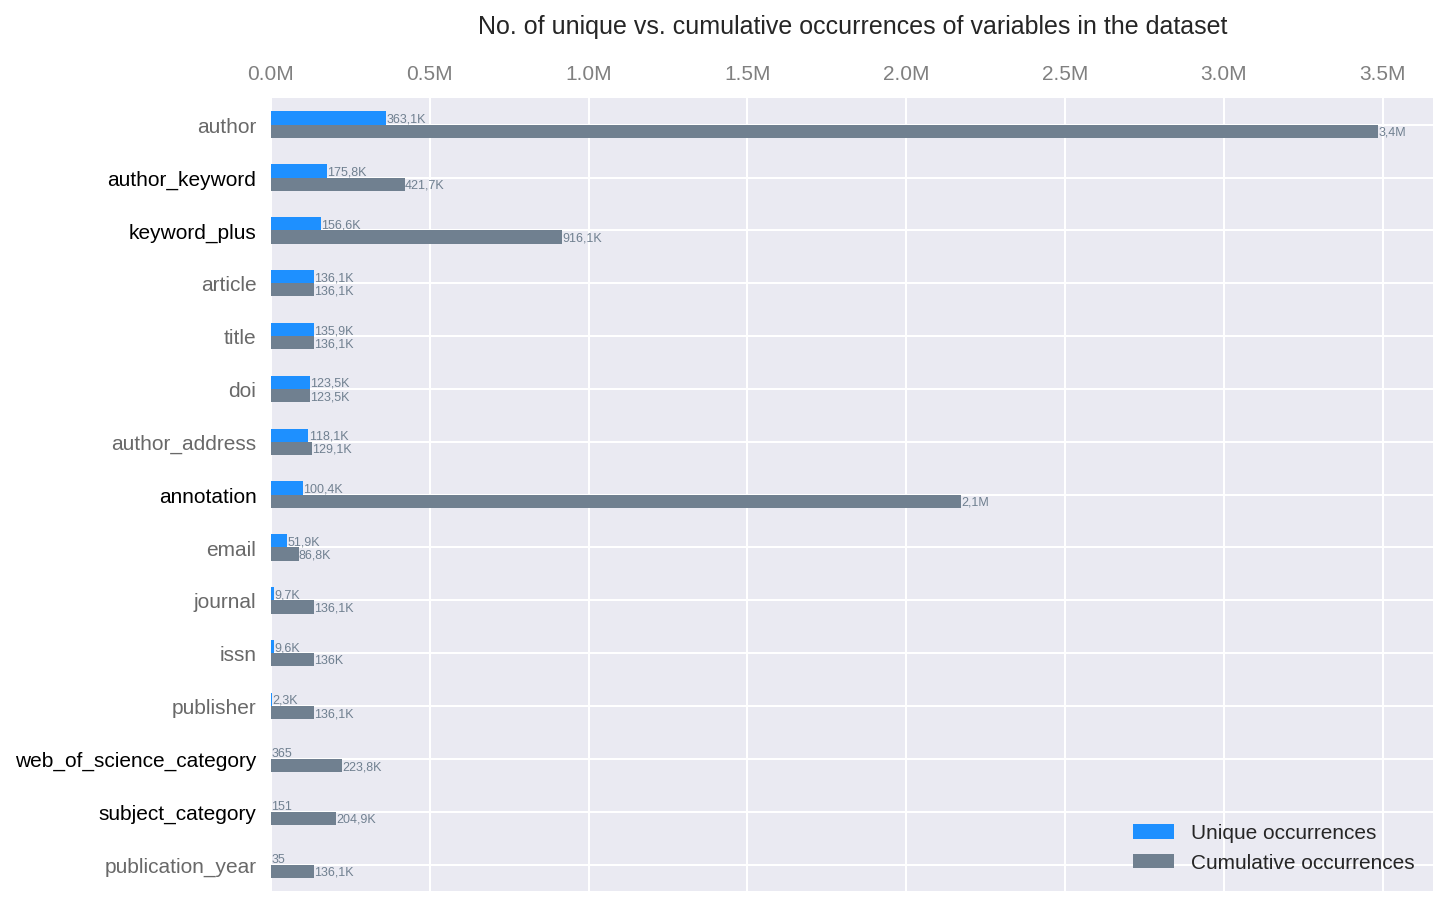

In [241]:
# set bar colors
bar_colors = ['dodgerblue', 'slategray']

ax1 = df_combined_counts.plot(kind='barh', color=bar_colors, figsize=(10,7))
plt.rcParams["figure.dpi"] = 150

# set title
ax1.set_title('No. of unique vs. cumulative occurrences of variables in the dataset', pad=15)

# reorder y axis from larger to smaller
ax1.invert_yaxis()

# change the default ticks and label color
ax1.tick_params(axis='y', colors='dimgray')
ax1.tick_params(axis='x', colors='grey')

# color topic tick labels on the y-axis
ax1.get_yticklabels()[1].set_color('black')
ax1.get_yticklabels()[2].set_color('black') 
ax1.get_yticklabels()[7].set_color('black') 
ax1.get_yticklabels()[-3].set_color('black') 
ax1.get_yticklabels()[-2].set_color('black') 

# color axes lines
# ax1.spines['top'].set_color('lightgray')
# ax1.spines['bottom'].set_color('lightgray')
# ax1.spines['left'].set_color('lightgray')
# ax1.spines['right'].set_color('lightgray')

# remove unnecessary axes lines
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

# # format the legend
# plt.setp(ax1.legend(frameon=True, prop={'size': 8}).get_texts(), color='dimgray')

# move ticks to the top for x axis
ax1.xaxis.tick_top()

# represent zeroes with 'M'
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: ("%.1f" % float(x/1000000)) + 'M'))


# x_offset = 1000000
# y_offset = 0.02
# for p in ax1.patches:
#     b = p.get_bbox()
#     val = "{:.0f}".format(b.x1 + b.x0)        
#     ax1.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))



# annotations =======================================================
# modified from/see a comprehensive guide for annotations at :
# http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

def format_number_string(string):
    string = str(string)
    if len(string) >= 4 and len(string) <= 6:
        if string[-3] != '0':
            return string[:-3] + ',' + string[-3] + 'K'
        else:
            return string[:-3] + 'K'
        
    elif len(string) >= 7 and len(string) <= 9:
        if string[-6] != '0':
            return string[:-6] + ',' + string[-6] + 'M'
        else:
            return string[:-6] + 'M'
    
    else:
        return string
        

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+700, i.get_y()+.20, \
            str(format_number_string(i.get_width())), fontsize=6, color='slategray'
    )
        
# ===================================================================
        

plt.show()

In [133]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

### Citations

**Get the actual has_cited counts (no cumulative/unique category):** 

As there are no repeating citations, this count is unary.

In [134]:
has_cited_count = eculture_query.send_count_query('citations', """
    SELECT (COUNT(?citedArticleTitle) as ?citations)
    WHERE{
        GRAPH wosGraph: {
            ?citingArticle a wos:Article ;
                           wos:CR ?citedArticle .
                     
            ?citedArticle rdfs:label ?citedArticleTitle .
        }
    }
""")

has_cited_count

5252226

**Compare internal vs external citations:** 

In [135]:
actual = no_of_article_cited_article_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?citedObjectInDatabase) AS ?count)
                                WHERE{
                                  GRAPH wosGraph: {
                                    ?article a wos:Article .
                                    ?article wos:CR ?citedArticle .
                                    ?citedArticle rdfs:label ?citedArticleTitle ;
                                                  wos:DOI ?citedArticleDoi ;
                                                  rdf:type ?citedArticleType .

                                    ?citedObjectInDatabase a wos:Article ;
                                                           wos:DOI ?citedArticleDoi .
                                  }
                                }
                            """,
                            query_variable_that_holds_count_results='count')
print('actual =', actual)

shadowed = no_of_article_cited_article_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?citedObjectInDatabase) AS ?count)
                                WHERE{
                                  GRAPH wosGraph: {
                                    ?article a wos:Article .
                                    ?article wos:CR ?citedArticle .
                                    ?citedArticle rdfs:label ?citedArticleTitle ;
                                                  wos:DOI ?citedArticleDoi ;
                                                  rdf:type ?citedArticleType .

                                    ?citedObjectInDatabase a wos:CitedPublication ;
                                                           wos:DOI ?citedArticleDoi .
                                  }
                                }
                            """,
                            query_variable_that_holds_count_results='count')

print('shadowed =', shadowed)

actual = 343202
shadowed = 3637471


In [245]:
actual_vs_shadowed_citations = pd.DataFrame({'records':[343202, 3637471]}, index=['Local', 'Outbound'])
actual_vs_shadowed_citations

,records
Local,343202
Outbound,3637471


Text(0.5, 1.0, 'No. of local vs. outbound citations in the dataset')

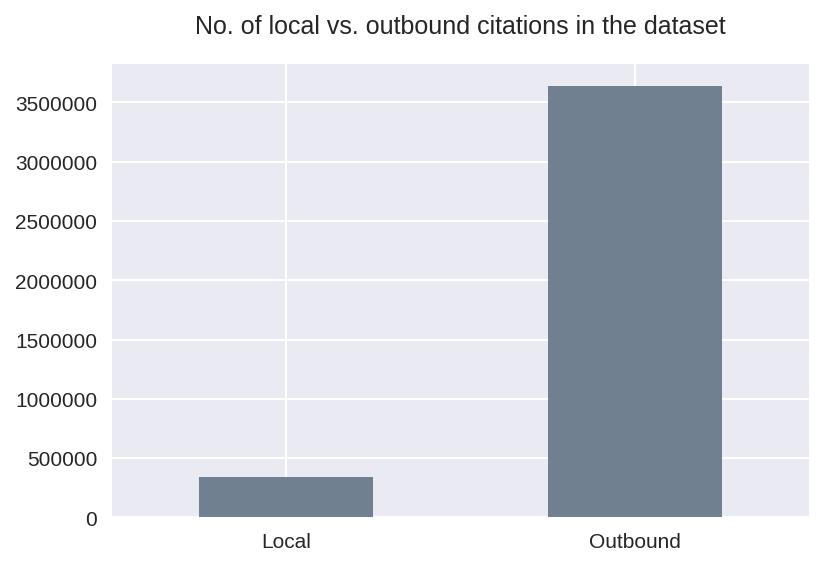

In [247]:
ax5 = actual_vs_shadowed_citations.plot(kind='bar', legend=False, rot=0, color=['slategray'])
plt.rcParams["figure.dpi"] = 150

ax5.set_title('No. of local vs. outbound citations in the dataset', pad=15)

**Get the actual has_cited counts (no cumulative/unique category):** 

### Year Distribution

In [138]:
years = eculture_query.send_select_query("""
    SELECT ?publication_year 
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                wos:PY ?publication_year .
        }
    }
""")

years.head()

,publication_year
0,1997
1,1997
2,1997
3,1997
4,1997


Text(0.5, 0, 'Years')

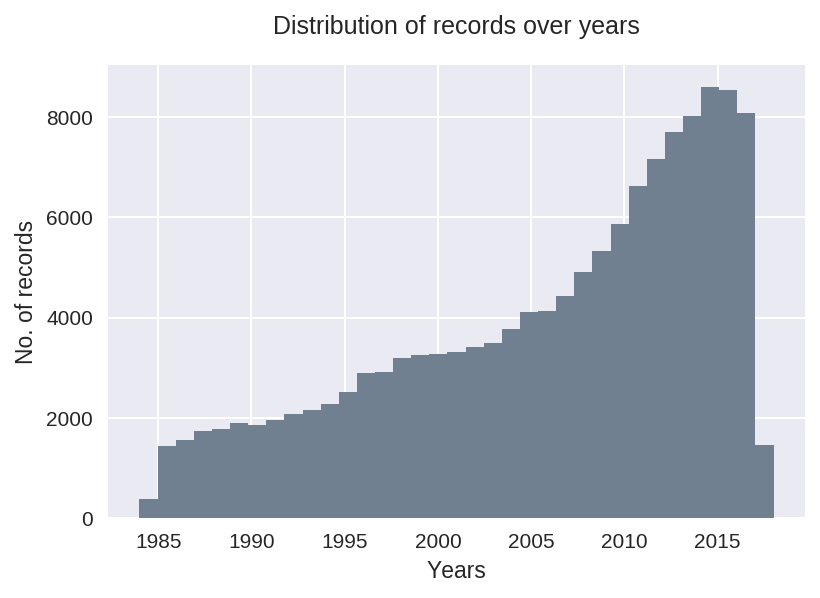

In [139]:
ax3 = years.plot.hist(color='slategray', bins=35, legend=False)
plt.rcParams["figure.dpi"] = 150

# set title
ax3.set_title('Distribution of records over years', pad=15)

# change the default ticks and label color
# ax3.tick_params(axis='y', colors='dimgray')
# ax3.tick_params(axis='x', colors='dimgray')

# set axis labels
ax3.set_ylabel('No. of records')
ax3.set_xlabel('Years')

# color axis labels
# ax3.yaxis.get_label().set_color('dimgray')
# ax3.xaxis.get_label().set_color('dimgray')

# # format the legend
# legend = plt.legend(['Publication year'], frameon=False)
# plt.setp(legend.get_texts(), color='dimgray')

# color axes lines
# ax3.spines['top'].set_color('lightgray')
# ax3.spines['bottom'].set_color('lightgray')
# ax3.spines['left'].set_color('lightgray')
# ax3.spines['right'].set_color('lightgray')

### VU and UvA Comparison

In [140]:
affiliations = eculture_query.send_select_query("""
    SELECT ?affiliation
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article;
                     wos:affiliatedWith ?affiliation .
        }
    }
""")

affiliations.head()

,affiliation
0,UvA
1,VU
2,VU
3,VU
4,VU


In [141]:
len(affiliations)

136125

In [142]:
affiliations.loc[affiliations['affiliation'] == 'UvA', :] = 'Universiteit van Amsterdam'
affiliations.loc[affiliations['affiliation'] == 'VU', :] = 'Vrije Universiteit Amsterdam'

In [143]:
affiliations.head(10)

,affiliation
0,Universiteit van Amsterdam
1,Vrije Universiteit Amsterdam
2,Vrije Universiteit Amsterdam
3,Vrije Universiteit Amsterdam
4,Vrije Universiteit Amsterdam
5,Vrije Universiteit Amsterdam
6,Vrije Universiteit Amsterdam
7,Vrije Universiteit Amsterdam
8,Universiteit van Amsterdam
9,Vrije Universiteit Amsterdam


In [144]:
uva_vu_value_counts = affiliations['affiliation'].value_counts()
uva_vu_value_counts

Vrije Universiteit Amsterdam    68505
Universiteit van Amsterdam      67620
Name: affiliation, dtype: int64

Text(0.5, 1.0, 'No. of records from the two universities that make up the database')

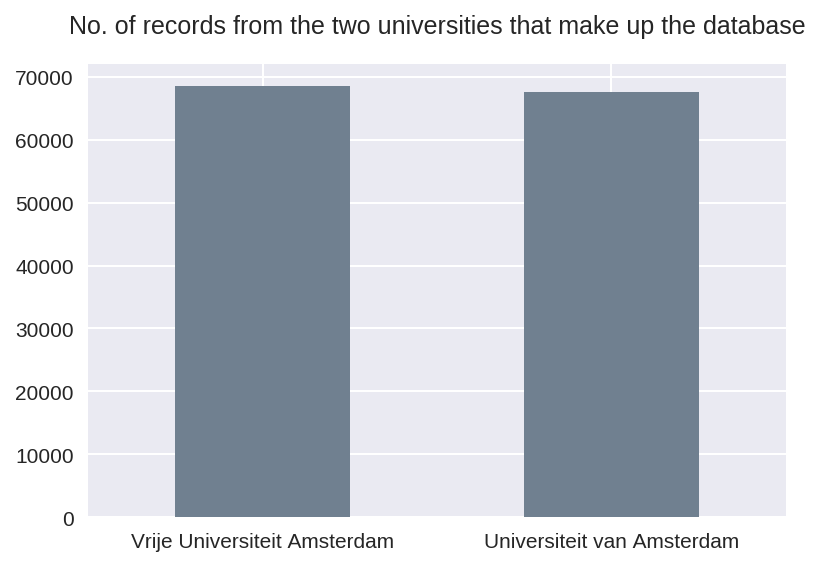

In [248]:
ax4 = uva_vu_value_counts.plot(kind='bar', color=['slategray', 'slategray'], rot=0)
plt.rcParams["figure.dpi"] = 150

# set title
ax4.set_title('No. of records from the two universities that make up the database', pad=15)

# change the default ticks and label color
# ax4.tick_params(axis='y', colors='dimgray')
# ax4.tick_params(axis='x', colors='dimgray')

# ax4.yaxis.get_label().set_color('dimgray')

# # format the legend
# legend = plt.legend(['Publication year'], frameon=False)
# plt.setp(legend.get_texts(), color='dimgray')

# color axes lines
# ax4.spines['top'].set_color('lightgray')
# ax4.spines['bottom'].set_color('lightgray')
# ax4.spines['left'].set_color('lightgray')
# ax4.spines['right'].set_color('lightgray')

## Statistics of Neo4j Database 

**Create a dataframe that contains the node and edge couns in Neo4j database**:

Note: These values are obtained via queries made in Neo4j.

In [223]:
neo4j_graph_counts = pd.DataFrame(
    index=['Keyword plus', 'Author keyword', 'Annotation', 'Web of Science category', 'Subject category'], 
    data={
        'No. of nodes': [156689, 175846, 100420, 365, 151],
        'No. of edges (unweighted)': [3655032, 1074924, 9093638, 126712, 86185],
        'No. of edges (weighted)': [2663482, 987558, 5126036, 2901, 1358]
    }
)

neo4j_graph_counts = neo4j_graph_counts.sort_values(by='No. of nodes', ascending=False)
neo4j_graph_counts

,No. of nodes,No. of edges (unweighted),No. of edges (weighted)
Author keyword,175846,1074924,987558
Keyword plus,156689,3655032,2663482
Annotation,100420,9093638,5126036
Web of Science category,365,126712,2901
Subject category,151,86185,1358


**Visualize the node and edge counts:**:

                         No. of edges (unweighted)  No. of edges (weighted)  No. of nodes
Subject category                             86185                     1358           151
Web of Science category                     126712                     2901           365
Author keyword                             1074924                   987558        175846
Keyword plus                               3655032                  2663482        156689
Annotation                                 9093638                  5126036        100420


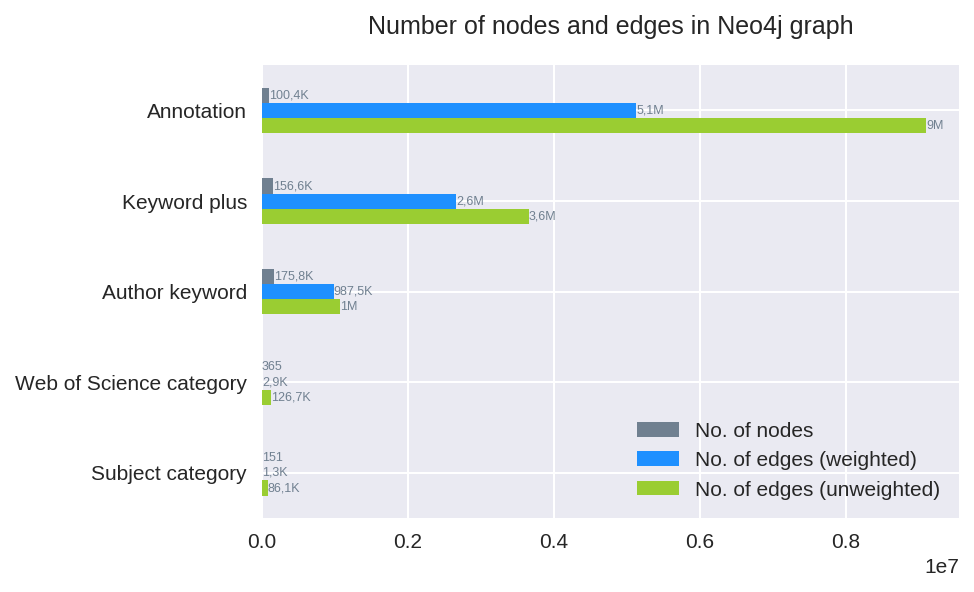

In [252]:
neo4j_graph_counts = neo4j_graph_counts.sort_values(by='No. of edges (unweighted)')

# reorder columns (otherwise they appear in the wrong order)
neo4j_graph_counts = neo4j_graph_counts[['No. of edges (unweighted)', 'No. of edges (weighted)', 'No. of nodes']]
print(neo4j_graph_counts)

# initiate plot
ax6 = neo4j_graph_counts.plot(kind='barh', color=['yellowgreen','dodgerblue','slategray'])
plt.rcParams["figure.dpi"] = 150

# set title
ax6.set_title('Number of nodes and edges in Neo4j graph', pad=15)

# set the order of legend items and legend position
handles, labels = ax6.get_legend_handles_labels()

handles = [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]

ax6.legend(handles,labels, loc='lower right')


# annotations =======================================================
# modified from/see a comprehensive guide for annotations at :
# http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

def format_number_string(string):
    string = str(string)
    if len(string) >= 4 and len(string) <= 6:
        if string[-3] != '0':
            return string[:-3] + ',' + string[-3] + 'K'
        else:
            return string[:-3] + 'K'
        
    elif len(string) >= 7 and len(string) <= 9:
        if string[-6] != '0':
            return string[:-6] + ',' + string[-6] + 'M'
        else:
            return string[:-6] + 'M'
    
    else:
        return string
        

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax6.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax6.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax6.text(i.get_width()+700, i.get_y()+.05, \
            str(format_number_string(i.get_width())), fontsize=6, color='slategray'
    )
        
# ===================================================================

plt.show()

**Reorder and re-sort the dataframe**:

In [232]:
neo4j_graph_counts = neo4j_graph_counts[['No. of nodes', 'No. of edges (unweighted)', 'No. of edges (weighted)']]
neo4j_graph_counts = neo4j_graph_counts.sort_values(by='No. of nodes', ascending=False)
neo4j_graph_counts

,No. of nodes,No. of edges (unweighted),No. of edges (weighted)
Author keyword,175846,1074924,987558
Keyword plus,156689,3655032,2663482
Annotation,100420,9093638,5126036
Web of Science category,365,126712,2901
Subject category,151,86185,1358


**Function to separate integers with commas:**

In [233]:
def separate_integer_with_commas(integer):
    separated_integer_as_string = '{val:,}'.format(val=integer)
    return separated_integer_as_string

**Display comma-separated counts as a table**:

In [234]:
neo4j_graph_counts.applymap(separate_integer_with_commas)

,No. of nodes,No. of edges (unweighted),No. of edges (weighted)
Author keyword,"175,846","1,074,924","987,558"
Keyword plus,"156,689","3,655,032","2,663,482"
Annotation,"100,420","9,093,638","5,126,036"
Web of Science category,365,"126,712","2,901"
Subject category,151,"86,185","1,358"


## Mapping and Transforming the Database

### Initialization

#### A Function for Retrieving all Sub-Attributes

A function to retrieve all attributes related to a target property (e.g., author --> author label, author alternative label)

In [13]:
def retrieve_all_sub_attributes (target_property_of_articles):    

    result = eculture_query.send_select_query("""
        SELECT DISTINCT ?p
        WHERE{
            GRAPH wosGraph: {
                ?article a wos:Article .
                ?article %s ?target_object .
                ?target_object ?p ?o .
            }
        }
    """ % target_property_of_articles)
    
    return result

### Titles

Titles have no other properties attached to them:

In [14]:
retrieve_all_sub_attributes('wos:TI')

,p


Display titles in a table:

In [37]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?title
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:TI ?title .
        }
    }
    LIMIT 10
    
""")

,wosArticleUri,title
0,wosres:WOS_000060208200006,Hollywood Berlin (The popularity of Nazi entertainment films in Germany under Hitler)
1,wosres:WOS_000070935900005,A randomized trial of anticoagulants versus aspirin after cerebral ischemia of presumed arterial...
2,wosres:WOS_000070948900005,The strength of numbers: Enumerating communities in India's princely states
3,wosres:WOS_000070961600011,Some patients with intracranial aneurysms have a reduced type III type I collagen ratio - A case...
4,wosres:WOS_000070961600033,Improving interobserver variation in reporting gadolinium-enhanced MRI lesions in multiple scler...
5,wosres:WOS_000070969600003,A physically active lifestyle - public health's best buy?
6,wosres:WOS_000070970500011,The effect of reciprocal treatments with ozone and ultraviolet-B radiation on photosynthesis and...
7,wosres:WOS_000070998100010,Compliance in administration of prescribed analgesics
8,wosres:WOS_000070998900007,Reconstruction of optical pathlength distributions from images obtained by a wide-field differen...
9,wosres:WOS_000071006900008,Does metformin increase the serum total homocysteine level in non-insulin-dependent diabetes mel...


Count the number of **article-title pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [39]:
no_of_article_title_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithTitle) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article .
                                       ?article wos:TI ?title .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithTitle')
no_of_article_title_pairs

136125

### Authors

In [30]:
retrieve_all_sub_attributes('wos:AF')

,p
0,rdf:type
1,rdfs:label
2,skos:altLabel


Display all attributes related to authors in a table:

In [40]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?author AS ?wosAuthorCompoundUri) ?authorName ?authorAltName
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:AF ?author .
            ?author rdfs:label ?authorName .
            ?author skos:altLabel ?authorAltName .
        }
    }
    LIMIT 10

""")

,wosArticleUri,wosAuthorCompoundUri,authorName,authorAltName
0,wosres:WOS_000060208200006,wosres:WOS_000060208200006_Elsaesser_T,"Elsaesser, T","Elsaesser, T"
1,wosres:WOS_000070998900007,wosres:WOS_000070998900007_Aten_JA,"Aten, JA","Aten, JA"
2,wosres:WOS_000070998900007,wosres:WOS_000070998900007_Van_Munster_EB,"Van Munster, EB","Van Munster, EB"
3,wosres:WOS_000070998900007,wosres:WOS_000070998900007_Van_Vliet_LJ,"Van Vliet, LJ","Van Vliet, LJ"
4,wosres:WOS_000071084600009,wosres:WOS_000071084600009_de_Beer_K,"de Beer, K","de Beer, K"
5,wosres:WOS_000071084600009,wosres:WOS_000071084600009_de_Voogt_P,"de Voogt, P","de Voogt, P"
6,wosres:WOS_000071084600009,wosres:WOS_000071084600009_van_der_Wielen_F,"van der Wielen, F","van der Wielen, F"
7,wosres:WOS_000071167500005,wosres:WOS_000071167500005_Faas_BHW,"Faas, BHW","Faas, BHW"
8,wosres:WOS_000071167500005,wosres:WOS_000071167500005_Ligthart_PC,"Ligthart, PC","Ligthart, PC"
9,wosres:WOS_000071167500005,wosres:WOS_000071167500005_Lomas-Francis_C,"Lomas-Francis, C","Lomas-Francis, C"


Count the number of **article-author pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [41]:
no_of_article_author_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?author) AS ?authors) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article .
                                       ?article wos:AF ?author .
                                       ?author rdfs:label ?authorName .
                                       ?author skos:altLabel ?authorAltName .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='authors')
no_of_article_author_pairs

3485373

Even though the 'maximum lines' and related 'query time' parameters are set to very liberal values, the the query still returns about 1 million lines maximum (possibly due to 100MB file size limit). Therefore, the query for Virtuoso GUI is entered 4 times, with differing OFFSET values (i.e., LIMIT = 1000000 OFFSET = 0, 1000000, 2000000, 3000000) 

### Years

'Years' has no attributes stemming from it:

In [141]:
retrieve_all_sub_attributes('wos:PY')

,p


Display all attributes related to years in a table:

In [145]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?publicationYear
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:PY ?publicationYear
        }
    }
    LIMIT 10

""")

,wosArticleUri,publicationYear
0,wosres:WOS_000060208200006,1997
1,wosres:WOS_000070935900005,1997
2,wosres:WOS_000070948900005,1997
3,wosres:WOS_000070961600011,1997
4,wosres:WOS_000070961600033,1997
5,wosres:WOS_000070969600003,1997
6,wosres:WOS_000070970500011,1997
7,wosres:WOS_000070998100010,1997
8,wosres:WOS_000070998900007,1997
9,wosres:WOS_000071006900008,1997


Count the number of **article-year pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [146]:
no_of_article_year_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithYears) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article ;
                                                wos:PY ?publicationYear
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithYears')
no_of_article_year_pairs

136125

### DOI

In [14]:
retrieve_all_sub_attributes('wos:DOI')

,p
0,rdf:type
1,rdfs:label
2,wos:DOI


Display all attributes related to DOI in a table:

In [42]:
eculture_query.send_select_query("""

    SELECT DISTINCT *
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:DOI ?doi .
                     
            ?doi rdfs:label ?doiLabel ;
                          wos:DOI ?doiDoi ;
                          a       ?doiType .
        }
    }
    LIMIT 10

""")

,article,doi,doiLabel,doiDoi,doiType
0,wosres:WOS_000070998900007,http://dx.doi.org/10.1046%2Fj.1365-2818.1997.2570815.x,"Van Munster EB, 1997, J MICROSC-OXFORD, V188, P149, DOI 10.1046/j.1365-2818.1997.2570815.x",http://dx.doi.org/10.1046%2Fj.1365-2818.1997.2570815.x,wos:CitedPublication
1,wosres:WOS_000071636500010,http://dx.doi.org/10.1002%2F(SICI)1096-9896(199801)184%3A1%3C53%3A%3AAID-PATH6%3E3.0.CO%3B2-7,"De Jong JS, 1998, J PATHOL, V184, P53, DOI 10.1002/(SICI)1096-9896(199801)184:1<53::AID-PATH6>3....",http://dx.doi.org/10.1002%2F(SICI)1096-9896(199801)184%3A1%3C53%3A%3AAID-PATH6%3E3.0.CO%3B2-7,wos:CitedPublication
2,wosres:WOS_000072954400012,http://dx.doi.org/10.1002%2Fana.410430413,"van den Berg JSP, 1998, ANN NEUROL, V43, P494, DOI 10.1002/ana.410430413",http://dx.doi.org/10.1002%2Fana.410430413,wos:CitedPublication
3,wosres:WOS_000071179700013,http://dx.doi.org/10.1006%2Fexer.1997.0396,"Broekhuyse RM, 1997, EXP EYE RES, V65, P841, DOI 10.1006/exer.1997.0396",http://dx.doi.org/10.1006%2Fexer.1997.0396,wos:CitedPublication
4,wosres:WOS_000071912700002,http://dx.doi.org/10.1006%2Fgcen.1997.7001,"de Lange RPJ, 1998, GEN COMP ENDOCR, V109, P166, DOI 10.1006/gcen.1997.7001",http://dx.doi.org/10.1006%2Fgcen.1997.7001,wos:CitedPublication
5,wosres:WOS_000074708500005,http://dx.doi.org/10.1006%2Fjdeq.1998.3428,"Gohberg I, 1998, J DIFFER EQUATIONS, V146, P375, DOI 10.1006/jdeq.1998.3428",http://dx.doi.org/10.1006%2Fjdeq.1998.3428,wos:CitedPublication
6,wosres:WOS_000073621000010,http://dx.doi.org/10.1007%2Fs002210050380,"Toussaint HM, 1998, EXP BRAIN RES, V120, P85, DOI 10.1007/s002210050380",http://dx.doi.org/10.1007%2Fs002210050380,wos:CitedPublication
7,wosres:WOS_000073621900004,http://dx.doi.org/10.1007%2Fs002510050382,"Bouma G, 1998, IMMUNOGENETICS, V47, P451, DOI 10.1007/s002510050382",http://dx.doi.org/10.1007%2Fs002510050382,wos:CitedPublication
8,wosres:WOS_000071074300003,http://dx.doi.org/10.1007%2Fs004320050111,"van der Wilt CL, 1997, J CANCER RES CLIN, V123, P595, DOI 10.1007/s004320050111",http://dx.doi.org/10.1007%2Fs004320050111,wos:CitedPublication
9,wosres:WOS_000074171100014,http://dx.doi.org/10.1007%2Fs004390050745,"Collee JM, 1998, HUM GENET, V102, P587, DOI 10.1007/s004390050745",http://dx.doi.org/10.1007%2Fs004390050745,wos:CitedPublication


Display only the attributes of interest:

In [55]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?doi
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:DOI ?doi .
        }
    }
    LIMIT 10

""")

,wosArticleUri,doi
0,wosres:WOS_000070948900005,http://dx.doi.org/10.1080%2F00856409708723290
1,wosres:WOS_000070961600011,http://dx.doi.org/10.1212%2FWNL.49.6.1546
2,wosres:WOS_000070961600033,http://dx.doi.org/10.1212%2FWNL.49.6.1682
3,wosres:WOS_000070969600003,http://dx.doi.org/10.1136%2Fbjsm.31.4.264
4,wosres:WOS_000070970500011,http://dx.doi.org/10.1016%2FS0269-7491(97)00085-7
5,wosres:WOS_000070998100010,http://dx.doi.org/10.1111%2Fj.1365-2044.1997.243-az0378.x
6,wosres:WOS_000070998900007,http://dx.doi.org/10.1046%2Fj.1365-2818.1997.2570815.x
7,wosres:WOS_000071006900008,http://dx.doi.org/10.1046%2Fj.1365-2796.1997.00231.x
8,wosres:WOS_000071013000007,http://dx.doi.org/10.1016%2FS0305-750X(97)00070-3
9,wosres:WOS_000071021600006,http://dx.doi.org/10.1023%2FA%3A1008601327920


Count the number of **article-doi pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [75]:
no_of_article_doi_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithDois) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article ;
                                                wos:DOI ?doi .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithDois')
no_of_article_doi_pairs

123531

### `Has Cited`

Articles have only the type, label, and DOIs of the articles they cited. That is, there is no separate property such as a `title` or `year` for the articles cited; instead, such information is included through the `rdfs:label` property.

In [57]:
retrieve_all_sub_attributes('wos:CR')

,p
0,rdf:type
1,rdfs:label
2,wos:DOI


Display all properties and objects related to has_cited in a table:

In [16]:
eculture_query.send_select_query("""

    SELECT DISTINCT *
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:CR ?citedArticle .
            ?citedArticle rdfs:label ?citedArticleTitle ;
                          wos:DOI ?citedArticleDoi ;
                          rdf:type ?citedArticleType .
        }
    }
    ORDER BY (?article)
    LIMIT 10

""")

,article,citedArticle,citedArticleTitle,citedArticleDoi,citedArticleType
0,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7,"WEINBERG H, 1994, J CHROMATOGR A, V671, P141, DOI 10.1016/0021-9673(94)80232-7",http://dx.doi.org/10.1016%2F0021-9673(94)80232-7,wos:CitedPublication
1,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1,"JOYCE RJ, 1994, J CHROMATOGR A, V671, P165, DOI 10.1016/0021-9673(94)80235-1",http://dx.doi.org/10.1016%2F0021-9673(94)80235-1,wos:CitedPublication
2,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5,"KALJURAND M, 1994, J CHROMATOGR A, V660, P147, DOI 10.1016/0021-9673(94)85108-5",http://dx.doi.org/10.1016%2F0021-9673(94)85108-5,wos:CitedPublication
3,wosres:WOS_000070924700022,http://dx.doi.org/10.1007%2FBF02268377,"KALJURAND M, 1992, CHROMATOGRAPHIA, V34, P417, DOI 10.1007/BF02268377",http://dx.doi.org/10.1007%2FBF02268377,wos:CitedPublication
4,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,"SMIT HC, 1986, ANAL CHIM ACTA, V181, P37, DOI 10.1016/S0003-2670(00)85218-6",http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,wos:CitedPublication
5,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O,"KAPPELLE LJ, 1991, LANCET, V337, P339, DOI 10.1016/0140-6736(91)90955-O",http://dx.doi.org/10.1016%2F0140-6736(91)90955-O,wos:CitedPublication
6,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6,"WARLOW C, 1992, LANCET, V339, P724, DOI 10.1016/0140-6736(92)90608-6",http://dx.doi.org/10.1016%2F0140-6736(92)90608-6,wos:CitedPublication
7,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4,"Azar AJ, 1996, J AM COLL CARDIOL, V27, P1349, DOI 10.1016/0735-1097(96)00020-4",http://dx.doi.org/10.1016%2F0735-1097(96)00020-4,wos:CitedPublication
8,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2FS0140-6736(94)90161-9,"ALGRA A, 1994, LANCET, V343, P1040, DOI 10.1016/S0140-6736(94)90161-9",http://dx.doi.org/10.1016%2FS0140-6736(94)90161-9,wos:CitedPublication
9,wosres:WOS_000070935900005,http://dx.doi.org/10.1056%2FNEJM199007193230302,"SMITH P, 1990, NEW ENGL J MED, V323, P147, DOI 10.1056/NEJM199007193230302",http://dx.doi.org/10.1056%2FNEJM199007193230302,wos:CitedPublication


Display **only** the attributes of interest:

In [18]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?citedArticleDoi AS ?hasCitedArticle_withDoi)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:CR ?citedArticle .
            ?citedArticle rdfs:label ?citedArticleTitle ;
                          wos:DOI ?citedArticleDoi ;
                          rdf:type ?citedArticleType .
        }
    }
    ORDER BY (?wosArticleUri)
    LIMIT 10

""")

,wosArticleUri,hasCitedArticle_withDoi
0,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7
1,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1
2,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5
3,wosres:WOS_000070924700022,http://dx.doi.org/10.1007%2FBF02268377
4,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6
5,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O
6,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6
7,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4
8,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2FS0140-6736(94)90161-9
9,wosres:WOS_000070935900005,http://dx.doi.org/10.1056%2FNEJM199007193230302


In the database, there two types of objects that are the targets of `wos:CR` (citation) property: `wos:Article` (actual article)and `wos:CitedPublication` (shadowed article). Shadowed citation objects are the outgoing citation relationships from the database, which are represented in the database with their basic information. In the results below, (`wos:Article` [and `wos:Publication`, which is its superclass] type objects are **actual, internal objects** [i.e., local-to-local connections], while `wos:CitedPublication` type entries are **shadowed objects** [i.e., local-to-external] objects.

**IMPORTANT: As rows 4, 5, and 6 could show, actual objects also has a shadow object, just like the external objects.**

Get **both actual and shadowed** citation ojects in database:

In [25]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?citedArticleDoi AS ?hasCitedArticle_withDoi) ?citedObjectType ?citedObjectInDatabase
    WHERE{
      GRAPH wosGraph: {
        ?article a wos:Article .
        ?article wos:CR ?citedArticle .
        ?citedArticle rdfs:label ?citedArticleTitle ;
                      wos:DOI ?citedArticleDoi ;
                      rdf:type ?citedArticleType .

        ?citedObjectInDatabase a ?type ;
                               wos:DOI ?citedArticleDoi ;
                               rdf:type ?citedObjectType .
      }
    }
    ORDER BY (?wosArticleUri)
    LIMIT 25

""")

,wosArticleUri,hasCitedArticle_withDoi,citedObjectType,citedObjectInDatabase
0,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7,wos:CitedPublication,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7
1,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1,wos:CitedPublication,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1
2,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5,wos:CitedPublication,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5
3,wosres:WOS_000070924700022,http://dx.doi.org/10.1007%2FBF02268377,wos:CitedPublication,http://dx.doi.org/10.1007%2FBF02268377
4,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,wos:Publication,wosres:WOS_A1986C636100003
5,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,wos:Article,wosres:WOS_A1986C636100003
6,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,wos:CitedPublication,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6
7,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O,wos:CitedPublication,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O
8,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6,wos:CitedPublication,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6
9,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4,wos:CitedPublication,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4


Get **only actual citation targets** (only the articles that actually in the database as an article entry; they start with `wosres:`):

In [27]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?citedArticleDoi AS ?hasCitedArticle_withDoi) ?citedObjectInDatabase
    WHERE{
      GRAPH wosGraph: {
        ?article a wos:Article .
        ?article wos:CR ?citedArticle .
        ?citedArticle rdfs:label ?citedArticleTitle ;
                      wos:DOI ?citedArticleDoi ;
                      rdf:type ?citedArticleType .

        ?citedObjectInDatabase a wos:Article ;
                               wos:DOI ?citedArticleDoi .
      }
    }
    ORDER BY (?wosArticleUri)
    LIMIT 25

""")

,wosArticleUri,hasCitedArticle_withDoi,citedObjectInDatabase
0,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,wosres:WOS_A1986C636100003
1,wosres:WOS_000070935900019,http://dx.doi.org/10.1042%2Fcs0870553,wosres:WOS_A1994PT80500013
2,wosres:WOS_000070941900001,http://dx.doi.org/10.1007%2FBF00999959,wosres:WOS_A1994MV22200014
3,wosres:WOS_000070961600011,http://dx.doi.org/10.1038%2Fng1293-359,wosres:WOS_A1993ML14500011
4,wosres:WOS_000070961600011,http://dx.doi.org/10.1136%2Fbmj.311.7000.288,wosres:WOS_A1995RM71900020
5,wosres:WOS_000070961600011,http://dx.doi.org/10.1038%2F317542a0,wosres:WOS_A1985ASE0900057
6,wosres:WOS_000070961600011,http://dx.doi.org/10.1161%2F01.STR.21.4.626,wosres:WOS_A1990CY88100019
7,wosres:WOS_000070961600033,http://dx.doi.org/10.1093%2Fbrain%2F116.5.1077,wosres:WOS_A1993MH34900005
8,wosres:WOS_000070961600033,http://dx.doi.org/10.1002%2Fana.410390104,wosres:WOS_A1996TT88000003
9,wosres:WOS_000070961600033,http://dx.doi.org/10.1007%2Fs004150050053,wosres:WOS_A1997WE02800003


Get **only shadowed citation targets** (only the entries that are representations of external articles; they start with `http://dx.doi.org`):

In [28]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?citedArticleDoi AS ?hasCitedArticle_withDoi) ?citedObjectInDatabase
    WHERE{
      GRAPH wosGraph: {
        ?article a wos:Article .
        ?article wos:CR ?citedArticle .
        ?citedArticle rdfs:label ?citedArticleTitle ;
                      wos:DOI ?citedArticleDoi ;
                      rdf:type ?citedArticleType .

        ?citedObjectInDatabase a wos:CitedPublication ;
                               wos:DOI ?citedArticleDoi .
      }
    }
    ORDER BY (?wosArticleUri)
    LIMIT 25

""")

,wosArticleUri,hasCitedArticle_withDoi,citedObjectInDatabase
0,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7,http://dx.doi.org/10.1016%2F0021-9673(94)80232-7
1,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1,http://dx.doi.org/10.1016%2F0021-9673(94)80235-1
2,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5,http://dx.doi.org/10.1016%2F0021-9673(94)85108-5
3,wosres:WOS_000070924700022,http://dx.doi.org/10.1007%2FBF02268377,http://dx.doi.org/10.1007%2FBF02268377
4,wosres:WOS_000070924700022,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6,http://dx.doi.org/10.1016%2FS0003-2670(00)85218-6
5,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O,http://dx.doi.org/10.1016%2F0140-6736(91)90955-O
6,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6,http://dx.doi.org/10.1016%2F0140-6736(92)90608-6
7,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4,http://dx.doi.org/10.1016%2F0735-1097(96)00020-4
8,wosres:WOS_000070935900005,http://dx.doi.org/10.1016%2FS0140-6736(94)90161-9,http://dx.doi.org/10.1016%2FS0140-6736(94)90161-9
9,wosres:WOS_000070935900005,http://dx.doi.org/10.1056%2FNEJM199007193230302,http://dx.doi.org/10.1056%2FNEJM199007193230302


What is the `**number of actual vs. shadowed** citation objects? 

(NOTE: As each actual object also has a shadowed objects, the two sets do overlap. Thus, calculatin the difference of the two counts would not yield the count of any unique type):

In [50]:
actual = no_of_article_cited_article_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?citedObjectInDatabase) AS ?count)
                                WHERE{
                                  GRAPH wosGraph: {
                                    ?article a wos:Article .
                                    ?article wos:CR ?citedArticle .
                                    ?citedArticle rdfs:label ?citedArticleTitle ;
                                                  wos:DOI ?citedArticleDoi ;
                                                  rdf:type ?citedArticleType .

                                    ?citedObjectInDatabase a wos:Article ;
                                                           wos:DOI ?citedArticleDoi .
                                  }
                                }
                            """,
                            query_variable_that_holds_count_results='count')
print('actual =', actual)

shadowed = no_of_article_cited_article_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?citedObjectInDatabase) AS ?count)
                                WHERE{
                                  GRAPH wosGraph: {
                                    ?article a wos:Article .
                                    ?article wos:CR ?citedArticle .
                                    ?citedArticle rdfs:label ?citedArticleTitle ;
                                                  wos:DOI ?citedArticleDoi ;
                                                  rdf:type ?citedArticleType .

                                    ?citedObjectInDatabase a wos:CitedPublication ;
                                                           wos:DOI ?citedArticleDoi .
                                  }
                                }
                            """,
                            query_variable_that_holds_count_results='count')

print('shadowed =', shadowed)

actual = 343202
shadowed = 3637471


Count the number of **article-has_cited pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [46]:
no_of_article_cited_article_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithCitedArticleDois) 
                               WHERE {
                                   GRAPH wosGraph:{
                                        ?article a wos:Article .
                                        ?article wos:CR ?citedArticle .
                                        ?citedArticle rdfs:label ?citedArticleTitle ;
                                                      wos:DOI ?citedArticleDoi ;
                                                      rdf:type ?citedArticleType .

                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithCitedArticleDois')
no_of_article_cited_article_pairs

3637471

Even though the 'maximum lines' and related 'query time' parameters are set to very liberal values, the the query still returns about 1 million lines maximum (possibly due to 100MB file size limit). Therefore, the query for Virtuoso GUI is entered 4 times, with differing OFFSET values (i.e., LIMIT = 1000000 OFFSET = 0, 1000000, 2000000, 3000000) 

### Journal

Journal has no other properties attached to it:

In [62]:
retrieve_all_sub_attributes('wos:SO')

,p


Display journals in a table:

In [15]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) (?source_publication AS ?journal)
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:SO ?source_publication .
        }
    }
    LIMIT 10
    
""")

,wosArticleUri,journal
0,wosres:WOS_000060208200006,SIGHT AND SOUND
1,wosres:WOS_000070935900005,ANNALS OF NEUROLOGY
2,wosres:WOS_000070948900005,SOUTH ASIA-JOURNAL OF SOUTH ASIAN STUDIES
3,wosres:WOS_000070961600011,NEUROLOGY
4,wosres:WOS_000070961600033,NEUROLOGY
5,wosres:WOS_000070969600003,BRITISH JOURNAL OF SPORTS MEDICINE
6,wosres:WOS_000070970500011,ENVIRONMENTAL POLLUTION
7,wosres:WOS_000070998100010,ANAESTHESIA
8,wosres:WOS_000070998900007,JOURNAL OF MICROSCOPY-OXFORD
9,wosres:WOS_000071006900008,JOURNAL OF INTERNAL MEDICINE


Journal names are all in capitals. All capital names are used only for relationships in Neo4j, which is where this dataset will be imported. Therefore, **convert all journal names to sentence case**:

In [42]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) 
           (    
                # Make journal names sentence case
                CONCAT(
                      SUBSTR(?source_publication, 1, 1),
                      LCASE(SUBSTR(?source_publication, 2))
                ) 
                AS ?journal
            )
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:SO ?source_publication .
        }
    }
    LIMIT 10
    
""")

,wosArticleUri,journal
0,wosres:WOS_000060208200006,Sight and sound
1,wosres:WOS_000070935900005,Annals of neurology
2,wosres:WOS_000070948900005,South asia-journal of south asian studies
3,wosres:WOS_000070961600011,Neurology
4,wosres:WOS_000070961600033,Neurology
5,wosres:WOS_000070969600003,British journal of sports medicine
6,wosres:WOS_000070970500011,Environmental pollution
7,wosres:WOS_000070998100010,Anaesthesia
8,wosres:WOS_000070998900007,Journal of microscopy-oxford
9,wosres:WOS_000071006900008,Journal of internal medicine


Count the number of **article-journal pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [72]:
no_of_article_journal_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithJournal) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article .
                                       ?article wos:SO ?source_publication .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithJournal')
no_of_article_journal_pairs

136125

### Subject Category

Subject Category has no other properties attached to it:

In [67]:
retrieve_all_sub_attributes('wos:SC')

,p


In [70]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?subjectCategory
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:SC ?subjectCategory .
        }
    }
    LIMIT 100
    
""")

,wosArticleUri,subjectCategory
0,wosres:WOS_000060208200006,"Film, Radio & Television"
1,wosres:WOS_000070935900005,Neurosciences & Neurology
2,wosres:WOS_000070948900005,Asian Studies
3,wosres:WOS_000070961600011,Neurosciences & Neurology
4,wosres:WOS_000070961600033,Neurosciences & Neurology
5,wosres:WOS_000070969600003,Sport Sciences
6,wosres:WOS_000070970500011,Environmental Sciences & Ecology
7,wosres:WOS_000070998100010,Anesthesiology
8,wosres:WOS_000070998900007,Microscopy
9,wosres:WOS_000071006900008,General & Internal Medicine


Count the number of **article-subject_category pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [71]:
no_of_article_category_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithSubCat) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article .
                                       ?article wos:SC ?subjectCategory .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithSubCat')
no_of_article_category_pairs

204928

### Annotations

Annotations has no other properties attached to it:

In [76]:
retrieve_all_sub_attributes('ldr:annotations')

,p
0,rdf:type
1,rdfs:label
2,ldr:similarityScore
3,ldr:uri
4,ldr:annotationDetail
5,ldr:surfaceForm
6,ldr:offset
7,ldr:percentageOfSecondRank


Display annotations on a table:

In [78]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?annotation
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article ldr:annotations ?annotation_instance .
            ?annotation_instance rdfs:label ?annotation
        }
    }
    LIMIT 100
    
""")

,wosArticleUri,annotation
0,wosres:WOS_000071167500005,blood group
1,wosres:WOS_000071084600009,surfactants
2,wosres:WOS_000070998900007,image processing
3,wosres:WOS_000070998900007,lateral shift
4,wosres:WOS_000071167500005,DNA
5,wosres:WOS_000070998900007,microscope
6,wosres:WOS_000071167500005,Serologic
7,wosres:WOS_000070998900007,signal-to-noise ratio
8,wosres:WOS_000071167500005,phenotype
9,wosres:WOS_000071167500005,expression


Count the number of **article-annotation pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [81]:
no_of_article_category_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithAnnotation) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article .
                                       ?article ldr:annotations ?annotation_instance .
                                       ?annotation_instance rdfs:label ?annotation
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithAnnotation')
no_of_article_category_pairs

2171532

Despite this count query's results, the actual number of returned lines is 1,322,491. As the queries return about 1 million lines maximum (possibly due to 100MB file size limit), these results were obtained from Virtuoso GUI with two 2 queries with differing OFFSET values (i.e., LIMIT = 1000000 OFFSET = 0, 1000000) 

### Keywords Plus

Keywords Plus has no other properties attached to it:

In [82]:
retrieve_all_sub_attributes('wos:ID')

,p


In [18]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?keywordsPlus
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:ID ?keywordsPlus .
        }
    }
    LIMIT 100
    
""")

,wosArticleUri,keywordsPlus
0,wosres:WOS_000070935900005,DISEASE
1,wosres:WOS_000070935900005,THERAPY
2,wosres:WOS_000070935900005,ACUTE MYOCARDIAL-INFARCTION
3,wosres:WOS_000070935900005,STROKE PATIENTS
4,wosres:WOS_000070935900005,HANDICAP
5,wosres:WOS_000070935900005,INTEROBSERVER AGREEMENT
6,wosres:WOS_000070935900005,INTRACEREBRAL HEMORRHAGE
7,wosres:WOS_000070935900005,BLEEDING COMPLICATIONS
8,wosres:WOS_000070935900005,OPTIMAL INTENSITY
9,wosres:WOS_000070935900005,WARFARIN


'Keywords plus' strings are all in capitals. All capital names are used only for relationships in Neo4j, which is where this dataset will be imported. Therefore, **convert all 'keywords plus' strings to sentence case**:

In [17]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) 
           (    
                # Make keywords plus sentence case
                CONCAT(
                      SUBSTR(?keywords_plus, 1, 1),
                      LCASE(SUBSTR(?keywords_plus, 2))
                ) 
                AS ?keywordsPlus
            )
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:ID ?keywords_plus .
        }
    }
    LIMIT 10
    
""")

,wosArticleUri,keywordsPlus
0,wosres:WOS_000070935900005,Disease
1,wosres:WOS_000070935900005,Therapy
2,wosres:WOS_000070935900005,Acute myocardial-infarction
3,wosres:WOS_000070935900005,Stroke patients
4,wosres:WOS_000070935900005,Handicap
5,wosres:WOS_000070935900005,Interobserver agreement
6,wosres:WOS_000070935900005,Intracerebral hemorrhage
7,wosres:WOS_000070935900005,Bleeding complications
8,wosres:WOS_000070935900005,Optimal intensity
9,wosres:WOS_000070935900005,Warfarin


Count the number of **article-keywords_plus pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [19]:
no_of_article_keywords_plus_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithKwPlus) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article ;
                                                wos:ID ?keywordPlus .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articlesWithKwPlus')
no_of_article_keywords_plus_pairs

916115

### Article Address

'Article address' has no other properties attached to it:

In [134]:
retrieve_all_sub_attributes('wos:C1')

,p


In [21]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?articleAddress
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:C1 ?articleAddress .
        }
    }
    LIMIT 25
    
""")

,wosArticleUri,articleAddress
0,wosres:WOS_000060208200006,"Univ Amsterdam, NL-1012 WX Amsterdam, Netherlands."
1,wosres:WOS_000070935900005,"Ziekenhuis De Wever & Gregorius Heerlen, Heerlen, Netherlands. Acad Ziekenhuis, Utrecht, Netherl..."
2,wosres:WOS_000070948900005,"Vrije Univ Amsterdam, Amsterdam, Netherlands."
3,wosres:WOS_000070961600011,"Univ Amsterdam, Acad Med Ctr, Dept Neurol, NL-1100 DD Amsterdam, Netherlands. Univ Amsterdam, Ac..."
4,wosres:WOS_000070961600033,"Free Univ Amsterdam Hosp, Dept Diagnost Radiol, MR Ctr MS Res, NL-1007 MB Amsterdam, Netherlands..."
5,wosres:WOS_000070969600003,"Free Univ Amsterdam, Fac Med, Inst Res Extramural Med, NL-1081 BT Amsterdam, Netherlands. Free U..."
6,wosres:WOS_000070970500011,"Free Univ Amsterdam, Dept Ecol & Ecotoxicol, NL-1081 HV Amsterdam, Netherlands. DLO, Res Inst Ag..."
7,wosres:WOS_000070998100010,"Vrije Univ Amsterdam, Acad Hosp, Dept Anaesthesiol, NL-1007 MB Amsterdam, Netherlands. Leiden Un..."
8,wosres:WOS_000070998900007,"Univ Amsterdam, Acad Med Ctr, Dept Radiotherapy, NL-1105 DE Amsterdam, Netherlands. Delft Univ T..."
9,wosres:WOS_000071006900008,"Vrije Univ Amsterdam, Inst Res Extramural Med, NL-1081 BT Amsterdam, Netherlands. Vrije Univ Ams..."


The addresses start with the institution name, and end with country name. This pattern can be used in order to extract institutions and countries:

In [81]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?articleAddress 
    
    #"TODO: Institutions needs to be tokenized properly.
    # Simple instution names work OK, but when there are commas in 
    # institution names results such as '[Maccarone' appear."
    # Also, some institution names are in all caps.
    #(STRBEFORE(?articleAddress, ',') AS ?institution).
    
    
    # TODO: Regex only finds substring match but does not return it.
    # This needs to be solved before country can be extracted 
    #(REGEX(?articleAddress, ',[^,]*$', '$1') AS ?country)
    
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:C1 ?articleAddress .
        }
    }
    LIMIT 25
    
""")

,wosArticleUri,articleAddress
0,wosres:WOS_000060208200006,"Univ Amsterdam, NL-1012 WX Amsterdam, Netherlands."
1,wosres:WOS_000070935900005,"Ziekenhuis De Wever & Gregorius Heerlen, Heerlen, Netherlands. Acad Ziekenhuis, Utrecht, Netherl..."
2,wosres:WOS_000070948900005,"Vrije Univ Amsterdam, Amsterdam, Netherlands."
3,wosres:WOS_000070961600011,"Univ Amsterdam, Acad Med Ctr, Dept Neurol, NL-1100 DD Amsterdam, Netherlands. Univ Amsterdam, Ac..."
4,wosres:WOS_000070961600033,"Free Univ Amsterdam Hosp, Dept Diagnost Radiol, MR Ctr MS Res, NL-1007 MB Amsterdam, Netherlands..."
5,wosres:WOS_000070969600003,"Free Univ Amsterdam, Fac Med, Inst Res Extramural Med, NL-1081 BT Amsterdam, Netherlands. Free U..."
6,wosres:WOS_000070970500011,"Free Univ Amsterdam, Dept Ecol & Ecotoxicol, NL-1081 HV Amsterdam, Netherlands. DLO, Res Inst Ag..."
7,wosres:WOS_000070998100010,"Vrije Univ Amsterdam, Acad Hosp, Dept Anaesthesiol, NL-1007 MB Amsterdam, Netherlands. Leiden Un..."
8,wosres:WOS_000070998900007,"Univ Amsterdam, Acad Med Ctr, Dept Radiotherapy, NL-1105 DE Amsterdam, Netherlands. Delft Univ T..."
9,wosres:WOS_000071006900008,"Vrije Univ Amsterdam, Inst Res Extramural Med, NL-1081 BT Amsterdam, Netherlands. Vrije Univ Ams..."


Count the number of **article-correspondence_adress pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [136]:
no_of_article_address_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articleWithAddress) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article ;
                                                wos:C1 ?address .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articleWithAddress')
no_of_article_address_pairs

129116

### Article Email

'Article email' has no other properties attached to it:

In [137]:
retrieve_all_sub_attributes('wos:EM')

,p


In [139]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?articleEmail
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:EM ?articleEmail .
        }
    }
    LIMIT 25
    
""")

,wosArticleUri,articleEmail
0,wosres:WOS_000071047000001,tgugt@nki.nl
1,wosres:WOS_000071077500014,kits@bio.vu.nl
2,wosres:WOS_000071174900006,zandberg@stm.tudelft.nl
3,wosres:WOS_000071196300003,DN.den.Hartog@psy.vu.nl
4,wosres:WOS_000071362800008,vminnen@bio.vu.nl
5,wosres:WOS_000071402800007,a417hell@chem.uva.nl
6,wosres:WOS_000071469300016,erker@uni-muenster.de
7,wosres:WOS_000071503900020,ellen.hoogeveen@paradigm.nl
8,wosres:WOS_000071519500005,prc@psu.edu
9,wosres:WOS_000071549800012,virgis@nat.vu.nl


Count the number of **article-correspondence_adress pairs**:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [140]:
no_of_article_email_pairs = eculture_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articleWithEmail) 
                               WHERE {
                                   GRAPH wosGraph:{
                                       ?article a wos:Article ;
                                                wos:EM ?articleEmail .
                                   }
                               }
                            """,
                            query_variable_that_holds_count_results='articleWithEmail')
no_of_article_email_pairs

86842

### Author Keywords

'Author keywords' has no other properties attached to it:

In [34]:
retrieve_all_sub_attributes('wos:DE')

,p


In [35]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?authorKeywords
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:DE ?authorKeywords .
        }
    }
    LIMIT 10
    
""")

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,Elymus athericus; growth; photosynthesis; ozone; UV-B radiation
1,wosres:WOS_000070998100010,"pain, postoperative; analgesics, prescribing"
2,wosres:WOS_000070998900007,DIC; Nomarski; interference; microscopy; CCD; image processing;
3,wosres:WOS_000070998900007,analysis; reconstruction; optical pathlength; phase; transparent; living
4,wosres:WOS_000071006900008,atherosclerosis; homocysteine; metformin; vitamin B-12
5,wosres:WOS_000071013000007,policy; household economics
6,wosres:WOS_000071013000007,sub-Saharan Africa; Swaziland; labor migration; food security; labor
7,wosres:WOS_000071021600006,nitric oxide radical; NO scavenging; thiol; S-nitrosothiol
8,wosres:WOS_000071021600006,(electrochemical); NO sensing
9,wosres:WOS_000071040300005,lumbar spine; vertebra; trabecular bone; Wolff's Law; intervertebral


 Because the keywords are in a semicolon-separated list, they need to be tokenized. Furthermore, keywords contain items such as "Wolff's Law" and "(electrochemical)". They need to be cleaned from special characters. These operations will be performed using the functionality developed for tokenizing, cleaning, and updating strings in the WoS triple store.

#### Initialize wos_query

Convert eculture_query (Gastrodon_Query class) to wos_query (WebOfScienceQuery class) to access tokenization and cleaning methods aimed for WOS database:

In [14]:
from retriever.sparql_tools import WebOfScienceQuery
from preprocessor.dataframe_tools import Data_Frame

In [15]:
wos_query = WebOfScienceQuery(eculture_query)

#### Use the Keywords Pipeline on the Entire WoS Graph to Tokenize and Clean Author Keywords

This separates and cleans all keywords in WoS Graph, and updates the graph with these processed keywords using the following structure: <br> *?article_id--kfir:hasAuthorKeyword-->?cleaned_keyword* structure.

(0) **CLEAN** KFIR Graph:

Delete all triples in the kfirGraph (separately from wosGraph, kfirGraph is where all the modified files are written):

In [100]:
# WARNING: Only to be used when resetting the graph. At other times, 
# the graph is likely to be populated.

#wos_query.send_update_query("""
#    CLEAR GRAPH kfirGraph:
#""")

Confirm deletions:

In [25]:
wos_query.send_select_query("""
    SELECT * {
        GRAPH kfirGraph: {
            ?s ?p ?o .
        }
    }
""")

,s,p,o


Tokenize and clean the literals:

In [39]:
# WARNING: This query takes about 30 minutes to complete
wos_query.tokenize_preprocess_and_update_string_literals(target_property_uri="wos:DE",
                                                         new_property_uri="kfir:hasAuthorKeyword",
                                                         uri_of_source_graph='wosGraph:',
                                                         uri_of_graph_to_write_the_output = 'kfirGraph:',
                                                         purify_string_literals=True,
                                                         query_batch_size=10000)


Tokenizing, preprocessing, and updating "wos:DE" literals: 100%|██████████████████| 14/14 [43:38<00:00, 187.02s/it]


Operation completed without errors.


Check KFIR graph:

(Tokenized & cleaned author keywords are connected to article ids with a new property)

In [40]:
wos_query.send_select_query("""
    SELECT * {
        GRAPH kfirGraph: {
            ?s kfir:hasAuthorKeyword ?o .
        }
    }
    LIMIT 10
    """
)       

,s,o
0,wosres:WOS_000070970500011,photosynthesis
1,wosres:WOS_000070970500011,ozone
2,wosres:WOS_000070970500011,UV-B radiation
3,wosres:WOS_000070970500011,growth
4,wosres:WOS_000070970500011,Elymus athericus
5,wosres:WOS_000070998100010,"pain, postoperative"
6,wosres:WOS_000070998100010,"analgesics, prescribing"
7,wosres:WOS_000070998900007,CCD
8,wosres:WOS_000070998900007,image processing
9,wosres:WOS_000070998900007,microscopy


Select articles and the preprocessed author keywords:

In [41]:
wos_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?authorKeyword
    WHERE {
        GRAPH kfirGraph: {
            ?article kfir:hasAuthorKeyword ?authorKeyword .
        }
    }
    LIMIT 100
    
""")

,wosArticleUri,authorKeyword
0,wosres:WOS_000070970500011,photosynthesis
1,wosres:WOS_000070970500011,ozone
2,wosres:WOS_000070970500011,UV-B radiation
3,wosres:WOS_000070970500011,growth
4,wosres:WOS_000070970500011,Elymus athericus
5,wosres:WOS_000070998100010,"pain, postoperative"
6,wosres:WOS_000070998100010,"analgesics, prescribing"
7,wosres:WOS_000070998900007,CCD
8,wosres:WOS_000070998900007,image processing
9,wosres:WOS_000070998900007,microscopy


Count the number of **article-author_keyword pairs** after preprocessing:

(This number also corresponds to the number of lines that will in the returned results if no LIMIT statement is used. The triple store (e.g., Virtuoso) must be configured to allow returning at least this many lines.)

In [42]:
no_of_article_au_keyword_pairs = wos_query.send_count_query(query=
                            """SELECT (COUNT(?article) AS ?articlesWithAuKeyword) 
                               WHERE {
                                   GRAPH kfirGraph:{
                                       ?article kfir:hasAuthorKeyword ?authorKeyword .
                                   }
                               }
                            """,
                         query_variable_that_holds_count_results='articlesWithAuKeyword')
no_of_article_au_keyword_pairs

421736

Count the number of **unique articles** that have keywords:

In [43]:
no_of_all_articles = wos_query.send_count_query(query=
                            """SELECT (COUNT(DISTINCT ?s) AS ?allArticles) 
                               WHERE {
                                   GRAPH kfirGraph:{
                                       ?s ?p ?o .
                                   }
                               }
                            """,
                         query_variable_that_holds_count_results='allArticles')

no_of_articles_with_keywords = wos_query.send_count_query(query=
                            """SELECT (COUNT(DISTINCT ?s) AS ?kwArticles) 
                               WHERE {
                                   GRAPH kfirGraph:{
                                       ?s kfir:hasAuthorKeyword ?o .
                                   }
                               }
                            """,
                         query_variable_that_holds_count_results='kwArticles')
print('All articles: ', no_of_all_articles)
print('Articles with keywords:', no_of_articles_with_keywords)

All articles:  136068
Articles with keywords: 77533


Count the number of **unique keywords**:

In [44]:
no_of_keywords = wos_query.send_count_query(query=
                        """SELECT (COUNT(DISTINCT ?o) AS ?keywords) 
                           WHERE {
                               GRAPH kfirGraph:{
                                   ?s kfir:hasAuthorKeyword ?o .
                                }
                        }""",
                         query_variable_that_holds_count_results='keywords')
no_of_keywords

175853

### Web of Science Category

Web of Science Category has no other properties attached to it:

In [14]:
retrieve_all_sub_attributes('wos:WC')

,p


In [15]:
eculture_query.send_select_query("""

    SELECT DISTINCT (?article AS ?wosArticleUri) ?webOfScienceCategory
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article .
            ?article wos:WC ?webOfScienceCategory .
        }
    }
    LIMIT 25
    
""")

,wosArticleUri,webOfScienceCategory
0,wosres:WOS_000060208200006,"Film, Radio, Television"
1,wosres:WOS_000070935900005,Clinical Neurology; Neurosciences
2,wosres:WOS_000070948900005,Asian Studies
3,wosres:WOS_000070961600011,Clinical Neurology
4,wosres:WOS_000070961600033,Clinical Neurology
5,wosres:WOS_000070969600003,Sport Sciences
6,wosres:WOS_000070970500011,Environmental Sciences
7,wosres:WOS_000070998100010,Anesthesiology
8,wosres:WOS_000070998900007,Microscopy
9,wosres:WOS_000071006900008,"Medicine, General & Internal"


Web of Science Categories also need to be tokenized and cleaned (see 'Author keywords' section for further explanations).

#### The Issues with Tokenization, String Fragmentation, and Random Semicolons

Issues in the original data:
1. **Tokenization**: The WoS keywords must be tokenized, as they are reprsented as semicolon separated strings in the original data.
- **String fragmentation**: Some items are tokenized incorrectly in the WoS data. For instance, 'Mathematical & Computational Biology' category is divided in two entities: 'Mathematical &' and 'Computational Biology'
3. **Random semicolons**: Semicolons sometimes appearing at the end of strings

A look at the **tokenization** and **string fragmentation** and **random semicolons** issues with a representative example:

In [18]:
wos_query.send_select_query("""
                        
    SELECT DISTINCT (?article AS ?wosArticleUri) ?wosCategories
    WHERE{
        GRAPH wosGraph: {
            ?article a wos:Article ;
                     wos:WC ?wosCategories .
        }
    }
    VALUES ?wosArticleUri {wosres:WOS_000080363400002}
    
""")

,wosArticleUri,wosCategories
0,wosres:WOS_000080363400002,Biochemical Research Methods; Biotechnology & Applied Microbiology;
1,wosres:WOS_000080363400002,Computational Biology; Statistics & Probability
2,wosres:WOS_000080363400002,"Computer Science, Interdisciplinary Applications; Mathematical &"


A look at the frequencies (note the many unique entities towards the end):

In [19]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?o as ?string_with_issue) (count(?o) as ?frequency)
    WHERE{
        GRAPH wosGraph: {
          ?s wos:WC ?o .
        }
    }
    ORDER BY DESC(?frequency)
""")

,string_with_issue,frequency
0,Oncology,4618
1,Multidisciplinary Sciences,4153
2,Cardiac & Cardiovascular Systems,4138
3,Gastroenterology & Hepatology,3889
4,"Medicine, General & Internal",3565
5,Endocrinology & Metabolism,3379
6,Astronomy & Astrophysics,3365
7,Rheumatology,3208
8,Hematology,2740
9,Pharmacology & Pharmacy,2584


How widespread are these issues?:

In [20]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?o as ?string_with_issue) (count(?o) as ?frequency)
    WHERE{
        GRAPH wosGraph: {
          ?s wos:WC ?o .
        }
      {FILTER STRENDS(?o, ';')}
      UNION
      {FILTER STRSTARTS(?o, ';')}
      UNION
      {FILTER STRSTARTS(?o, '&')}
      UNION
      {FILTER (STRENDS(?o, '&'))}
    }
    ORDER BY DESC(?frequency)
""")

,string_with_issue,frequency
0,"Endocrinology & Metabolism; Genetics & Heredity; Medicine, Research &",799
1,"Psychology, Biological; Neurosciences; Physiology; Psychology;",390
2,"Chemistry, Physical; Materials Science, Multidisciplinary; Metallurgy &",237
3,"Psychology, Clinical; Geriatrics & Gerontology; Gerontology; Psychiatry;",222
4,Biochemical Research Methods; Biotechnology & Applied Microbiology;,192
5,"Computer Science, Artificial Intelligence; Engineering, Electrical &",180
6,Biochemistry & Molecular Biology; Biotechnology & Applied Microbiology;,175
7,Biochemical Research Methods; Biochemistry & Molecular Biology;,154
8,"Computer Science, Interdisciplinary Applications; Information Science &",144
9,"Education, Special; Genetics & Heredity; Clinical Neurology; Psychiatry;",124


#### Tokenization, Cleaning, and Defragmentation of WoS Categories

Convert eculture_query (Gastrodon_Query class) to wos_query (WebOfScienceQuery class) to access tokenization and cleaning methods aimed for WOS database:

In [21]:
from retriever.sparql_tools import WebOfScienceQuery
from preprocessor.dataframe_tools import Data_Frame

In [22]:
wos_query = WebOfScienceQuery(eculture_query)

Import the entire list of web of science categories:

In [25]:
from preprocessor.string_tools import String
from pprint import pprint

complete_list_of_wos_categories = []

with open('..//ontologies/wos_categories/complete_list_of_wos_categories.txt') as wos_categories_file:
    for each_line in wos_categories_file:
        each_line = String(each_line)
        each_line = each_line.clean_from_newline_characters()
        complete_list_of_wos_categories.append(each_line.content)
pprint(complete_list_of_wos_categories)

['wosCategory; replacement; parent',
 'Acoustics',
 'Agricultural Economics & Policy',
 'Agricultural Engineering',
 'Agriculture, Dairy & Animal Science',
 'Agriculture, Multidisciplinary',
 'Agronomy',
 'Allergy',
 'Anatomy & Morphology',
 'Andrology',
 'Anesthesiology',
 'Anthropology',
 'Archaeology',
 'Architecture',
 'Area Studies',
 'Art',
 'Asian Studies',
 'Astronomy & Astrophysics',
 'Audiology & Speech-Language Pathology',
 'Automation & Control Systems',
 'Behavioral Sciences',
 'Biochemical Research Methods',
 'Biochemistry & Molecular Biology',
 'Biodiversity Conservation',
 'Biology',
 'Biophysics',
 'Biotechnology & Applied Microbiology',
 'Business',
 'Business, Finance',
 'Cardiac & Cardiovascular Systems',
 'Cell & Tissue Engineering',
 'Cell Biology',
 'Chemistry, Analytical',
 'Chemistry, Applied',
 'Chemistry, Inorganic & Nuclear',
 'Chemistry, Medicinal',
 'Chemistry, Multidisciplinary',
 'Chemistry, Organic',
 'Chemistry, Physical',
 'Classics',
 'Clinical Neuro

Tokenize and reconstuct the Web of Science categories by checking every entry against the complete_list_of_wos_categories:

In [115]:
# WARNING: This query takes about 30 minutes to complete
wos_query.tokenize_preprocess_and_update_string_literals(target_property_uri='wos:WC', 
                                                         new_property_uri='kfir:hasWosCategory',
                                                         uri_of_source_graph='wosGraph:',
                                                         uri_of_graph_to_write_the_output='kfirGraph:',
                                                         defragment_string_literals_using_list=complete_list_of_wos_categories,
                                                         fragmentation_signalling_character='&',
                                                         query_batch_size=10000)


Tokenizing, preprocessing, and updating "wos:WC" literals:  20%|███▊               | 3/15 [07:31<30:06, 150.52s/it]

Language & Linguistics
Language & Linguistics


Tokenizing, preprocessing, and updating "wos:WC" literals:  27%|█████              | 4/15 [09:59<27:27, 149.81s/it]

Language & Linguistics
Language & Linguistics
Error caught. So far, 1 error(s) have been logged.
Error caught. So far, 2 error(s) have been logged.


Tokenizing, preprocessing, and updating "wos:WC" literals:  80%|██████████████▍   | 12/15 [29:28<07:22, 147.36s/it]

Language & Linguistics
Language & Linguistics


Tokenizing, preprocessing, and updating "wos:WC" literals: 100%|██████████████████| 15/15 [35:35<00:00, 142.37s/it]


Operation completed.
These 2 errors were logged during the operation:
Error caught at offset 40000 while trying to send an update query to the server to upload this preprocessed dataframe:
                    wosArticleUri  \
0     wosres:WOS_000358055700009   
1     wosres:WOS_000358059200003   
2     wosres:WOS_000358062100007   
3     wosres:WOS_000358064500030   
4     wosres:WOS_000358068300003   
5     wosres:WOS_000358081200013   
6     wosres:WOS_000358090800010   
7     wosres:WOS_000358091800031   
8     wosres:WOS_000358097800007   
9     wosres:WOS_000358097800009   
10    wosres:WOS_000358103200006   
11    wosres:WOS_000358104800026   
12    wosres:WOS_000358122500001   
13    wosres:WOS_000358130800007   
14    wosres:WOS_000358130800015   
15    wosres:WOS_000358136900008   
16    wosres:WOS_000358143500002   
17    wosres:WOS_000358153000015   
18    wosres:WOS_000358153000036   
19    wosres:WOS_000358164600002   
20    wosres:WOS_000358178900005   
21    wosres:WOS_0

String defragmentation **seems to be successful**. After the operation, there is only a small ratio of problematic strings remains. This is likely to be caused by the fact that the preprocesing was done in batches, and thus, the counterpart of a string may have been present in the next/previous batch due to the cutoff of results between the two batches. (The only exception to this seems to be the 'GREEN & SUSTAINABLE SCIENCE &' which is likely not matched with anything due to its unique formatting).

This hypothesis is indeed confirmed by modifying the batch size. With a batch size of 10000, the number of remaining fragmented strings were significatly less when compared to a an operation with batch size of 100 and 1000. (Higher batch sizes were not attempted due to resource constraints). Furthermore, the erroneous strings and their frequencies remained exactly the same when the process was run a second time with the same batch size.

**Stats of erroneous WoS categories after preprocesing**:

In [26]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?o as ?string_with_issue) (count(?o) as ?frequency)
    WHERE{
        GRAPH kfirGraph: {
          ?s kfir:hasWosCategory ?o .
        }
      {FILTER STRENDS(?o, ';')}
      UNION
      {FILTER STRSTARTS(?o, ';')}
      UNION
      {FILTER STRSTARTS(?o, '&')}
      UNION
      {FILTER (STRENDS(?o, '&'))}
    }
    ORDER BY DESC(?frequency)

""")

,string_with_issue,frequency
0,"Medicine, Research &",23
1,& Philosophy Of Science,12
2,History &,6
3,Language &,3
4,GREEN & SUSTAINABLE SCIENCE &,2


**Preview of preprocessed data (WoS categories)**:

In [27]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?s as ?wosArticleUri) (?o as ?wosCategory)
    WHERE{
        GRAPH kfirGraph: {
          ?s kfir:hasWosCategory ?o .
        }
    }
    LIMIT 100
""")

,wosArticleUri,wosCategory
0,wosres:WOS_000060208200006,"Film, Radio, Television"
1,wosres:WOS_000070935900005,Clinical Neurology
2,wosres:WOS_000070935900005,Neurosciences
3,wosres:WOS_000070948900005,Asian Studies
4,wosres:WOS_000070961600011,Clinical Neurology
5,wosres:WOS_000070961600033,Clinical Neurology
6,wosres:WOS_000070969600003,Sport Sciences
7,wosres:WOS_000070970500011,Environmental Sciences
8,wosres:WOS_000070998100010,Anesthesiology
9,wosres:WOS_000070998900007,Microscopy


Count the number of **unique wos_categories**:

In [33]:
no_of_categories = wos_query.send_count_query(query=
                        """SELECT (COUNT(DISTINCT ?o) AS ?categories) 
                           WHERE {
                               GRAPH kfirGraph:{
                                   ?s kfir:hasWosCategory ?o .
                                }
                        }""",
                         query_variable_that_holds_count_results='categories')
no_of_categories

365

#### Descriptive Statistics of the Preprocessed WoS Categories Data vs Original Data:

**Preprocessed data**:

(This number also corresponds to **the number of lines that will be in the returned results**. The triple store (e.g., Virtuoso) must be configured to allow returning *at least* this many lines.)

In [28]:
wos_query.send_select_query("""
    
    SELECT (COUNT(?o) as ?no_of_triples_with_wos_categories) (COUNT(DISTINCT ?s) as ?no_of_unique_articles) (COUNT(DISTINCT ?o) as ?no_of_unique_wos_categories)
    WHERE{
        GRAPH kfirGraph: {
          ?s kfir:hasWosCategory ?o .
        }
    }

""")

,no_of_triples_with_wos_categories,no_of_unique_articles,no_of_unique_wos_categories
0,223849,136047,365


**Original data**:

In [29]:
wos_query.send_select_query("""
    
    SELECT (COUNT(?o) as ?no_of_triples_with_wos_categories) (COUNT(DISTINCT ?s) as ?no_of_unique_articles) (COUNT(DISTINCT ?o) as ?no_of_unique_wos_categories)
    WHERE{
        GRAPH wosGraph: {
          ?s wos:WC ?o .
        }
    }

""")

,no_of_triples_with_wos_categories,no_of_unique_articles,no_of_unique_wos_categories
0,211476,198337,2572


**Preprocessed data**:

In [30]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?o as ?string_with_issue) (count(?o) as ?frequency)
    WHERE{
        GRAPH kfirGraph: {
          ?s kfir:hasWosCategory ?o .
        }
    }
    ORDER BY DESC(?frequency)
""")

,string_with_issue,frequency
0,Neurosciences,6624
1,Biochemistry & Molecular Biology,6190
2,Oncology,5389
3,Clinical Neurology,4850
4,Psychiatry,4645
5,Astronomy & Astrophysics,4425
6,Immunology,4367
7,Genetics & Heredity,3972
8,Multidisciplinary Sciences,3835
9,Cardiac & Cardiovascular Systems,3621


**Original data**:

In [31]:
wos_query.send_select_query("""
    
    SELECT DISTINCT (?o as ?string_with_issue) (count(?o) as ?frequency)
    WHERE{
        GRAPH wosGraph: {
          ?s wos:WC ?o .
        }
    }
    ORDER BY DESC(?frequency)
""")

,string_with_issue,frequency
0,Oncology,4618
1,Multidisciplinary Sciences,4153
2,Cardiac & Cardiovascular Systems,4138
3,Gastroenterology & Hepatology,3889
4,"Medicine, General & Internal",3565
5,Endocrinology & Metabolism,3379
6,Astronomy & Astrophysics,3365
7,Rheumatology,3208
8,Hematology,2740
9,Pharmacology & Pharmacy,2584


# APPENDIX

## Step-by-step Processing Pipeline for Author Keywords 
**(Unpacked tokenize_purify_and_update_string_literals method)**

'Keywords' has no other properties attached to it:

In [47]:
retrieve_all_sub_attributes('wos:DE')

,p


### Building the Keyword Processing Pipeline and Testing it on Part of the WoS Graph

In [48]:
from retriever.sparql_tools import WebOfScienceQuery
from preprocessor.dataframe_tools import Data_Frame

In [49]:
wos_query = WebOfScienceQuery(eculture_query)

**Step 1:** Retrieve a test dataset (using LIMIT ...) containing article ids and associated keywords:

In [50]:
ids_vs_keywords = wos_query.retrieve_relationships_of_property('wos:DE',
                                                               desired_column_name_for_literal='authorKeywords',
                                                               limit=10)
ids_vs_keywords

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,Elymus athericus; growth; photosynthesis; ozone; UV-B radiation
1,wosres:WOS_000070998100010,"pain, postoperative; analgesics, prescribing"
2,wosres:WOS_000070998900007,DIC; Nomarski; interference; microscopy; CCD; image processing;
3,wosres:WOS_000070998900007,analysis; reconstruction; optical pathlength; phase; transparent; living
4,wosres:WOS_000071006900008,atherosclerosis; homocysteine; metformin; vitamin B-12
5,wosres:WOS_000071013000007,policy; household economics
6,wosres:WOS_000071013000007,sub-Saharan Africa; Swaziland; labor migration; food security; labor
7,wosres:WOS_000071021600006,nitric oxide radical; NO scavenging; thiol; S-nitrosothiol
8,wosres:WOS_000071021600006,(electrochemical); NO sensing
9,wosres:WOS_000071040300005,lumbar spine; vertebra; trabecular bone; Wolff's Law; intervertebral


**Step 2:** Because the keywords are in a semicolon-separated list, they need to be tokenized:

In [51]:
ids_vs_keywords = Data_Frame(ids_vs_keywords)  # this is not 'pandas.DataFrame' class
ids_vs_keywords.tokenize_string_column(string_column_name='authorKeywords', 
                                       id_column_name='wosArticleUri', 
                                       delimiter_pattern_in_literal_cells='; ')
ids_vs_keywords.dataframe

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,Elymus athericus
1,wosres:WOS_000070970500011,growth
2,wosres:WOS_000070970500011,photosynthesis
3,wosres:WOS_000070970500011,ozone
4,wosres:WOS_000070970500011,UV-B radiation
5,wosres:WOS_000070998100010,"pain, postoperative"
6,wosres:WOS_000070998100010,"analgesics, prescribing"
7,wosres:WOS_000070998900007,DIC
8,wosres:WOS_000070998900007,Nomarski
9,wosres:WOS_000070998900007,interference


**Step 3:** Tokenized keywords contain items such as "Wolff's Law" and "(electrochemical)". They need to be cleaned from special characters:

In [52]:
ids_vs_keywords.purify_column(target_column_name='authorKeywords')
ids_vs_keywords.dataframe

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,Elymus athericus
1,wosres:WOS_000070970500011,growth
2,wosres:WOS_000070970500011,photosynthesis
3,wosres:WOS_000070970500011,ozone
4,wosres:WOS_000070970500011,UV-B radiation
5,wosres:WOS_000070998100010,"pain, postoperative"
6,wosres:WOS_000070998100010,"analgesics, prescribing"
7,wosres:WOS_000070998900007,DIC
8,wosres:WOS_000070998900007,Nomarski
9,wosres:WOS_000070998900007,interference


**Step 4:** Collapse the keywords onto article uris as lists:

In [53]:
ids_vs_keywords = ids_vs_keywords.collapse_dataframe_on_column(values_column_name='authorKeywords', identifier_column_name='wosArticleUri')
ids_vs_keywords.dataframe

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,"[Elymus athericus, growth, photosynthesis, ozone, UV-B radiation]"
1,wosres:WOS_000070998100010,"[pain, postoperative, analgesics, prescribing]"
2,wosres:WOS_000070998900007,"[DIC, Nomarski, interference, microscopy, CCD, image processing, analysis, reconstruction, optic..."
3,wosres:WOS_000071006900008,"[atherosclerosis, homocysteine, metformin, vitamin B-12]"
4,wosres:WOS_000071013000007,"[policy, household economics, sub-Saharan Africa, Swaziland, labor migration, food security, labor]"
5,wosres:WOS_000071021600006,"[nitric oxide radical, NO scavenging, thiol, S-nitrosothiol, electrochemical, NO sensing]"
6,wosres:WOS_000071040300005,"[lumbar spine, vertebra, trabecular bone, Wolffs Law, intervertebral]"


**Step 5**: Prepare strings to be later passed on to VALUES keyword in Gastrodon_Query:<br>
(This alleviates the need to send one SPARQL query per keyword, and instead, will be used to group keywords per article ID using the VALUES keyword)

In [54]:
from retriever.sparql_tools import Sparql_Parameter

In [55]:
# Extract the author keywords column
author_keywords_column = ids_vs_keywords.dataframe['authorKeywords']

# Convert lists on each cell of author keywords column to parameter strings
parameterized_keywords = Sparql_Parameter.Values_Parameter_Series()
parameterized_keywords.import_and_convert_pandas_series(author_keywords_column)

# Replace the author keywords column of the dataframe with the parameterized version 
ids_vs_keywords.dataframe['authorKeywords'] = parameterized_keywords.series
ids_vs_keywords.dataframe

,wosArticleUri,authorKeywords
0,wosres:WOS_000070970500011,"""Elymus athericus"" ""growth"" ""photosynthesis"" ""ozone"" ""UV-B radiation"""
1,wosres:WOS_000070998100010,"""pain, postoperative"" ""analgesics, prescribing"""
2,wosres:WOS_000070998900007,"""DIC"" ""Nomarski"" ""interference"" ""microscopy"" ""CCD"" ""image processing"" ""analysis"" ""reconstruction..."
3,wosres:WOS_000071006900008,"""atherosclerosis"" ""homocysteine"" ""metformin"" ""vitamin B-12"""
4,wosres:WOS_000071013000007,"""policy"" ""household economics"" ""sub-Saharan Africa"" ""Swaziland"" ""labor migration"" ""food security..."
5,wosres:WOS_000071021600006,"""nitric oxide radical"" ""NO scavenging"" ""thiol"" ""S-nitrosothiol"" ""electrochemical"" ""NO sensing"""
6,wosres:WOS_000071040300005,"""lumbar spine"" ""vertebra"" ""trabecular bone"" ""Wolffs Law"" ""intervertebral"""


Clean the test graph and confirm that it is empty:

In [36]:
wos_query.send_update_query("""
    CLEAR GRAPH testGraph:
""")

wos_query.send_select_query("""
    SELECT * {
        GRAPH testGraph: {
            ?s ?p ?o .
        }
    }
""")

C:\ProgramData\Anaconda3\lib\site-packages\SPARQLWrapper\Wrapper.py:585: RuntimeWarning:

Sending Accept header '*/*' because unexpected returned format 'json' in a 'CLEAR' SPARQL query form



,s,p,o


**Step 6**: Update the test graph using the parameterised keywords:

In [57]:
for index, each_row in ids_vs_keywords.dataframe.iterrows():
    each_article_id = each_row.values[0]
    each_parameter_string = each_row.values[1]
    wos_query.send_update_query("""
    
        INSERT {
            GRAPH testGraph: {
                %s kfir:hasAuthorKeyword ?keyword
            }
        }
        WHERE{
            VALUES ?keyword {%s}
        }
        
    """ % (each_article_id, each_parameter_string)
    )

Confirm the update:

In [58]:
wos_query.send_select_query("""
    SELECT * {
        GRAPH testGraph: {
            ?s ?p ?o .
        }
    }
""")

,s,p,o
0,wosres:WOS_000070970500011,kfir:hasAuthorKeyword,photosynthesis
1,wosres:WOS_000070970500011,kfir:hasAuthorKeyword,ozone
2,wosres:WOS_000070970500011,kfir:hasAuthorKeyword,UV-B radiation
3,wosres:WOS_000070970500011,kfir:hasAuthorKeyword,growth
4,wosres:WOS_000070970500011,kfir:hasAuthorKeyword,Elymus athericus
5,wosres:WOS_000070998100010,kfir:hasAuthorKeyword,"pain, postoperative"
6,wosres:WOS_000070998100010,kfir:hasAuthorKeyword,"analgesics, prescribing"
7,wosres:WOS_000070998900007,kfir:hasAuthorKeyword,CCD
8,wosres:WOS_000070998900007,kfir:hasAuthorKeyword,image processing
9,wosres:WOS_000070998900007,kfir:hasAuthorKeyword,microscopy


# Experimentation

##### Plotting Experiment: Unique Value Counts 

**Plot the results**:

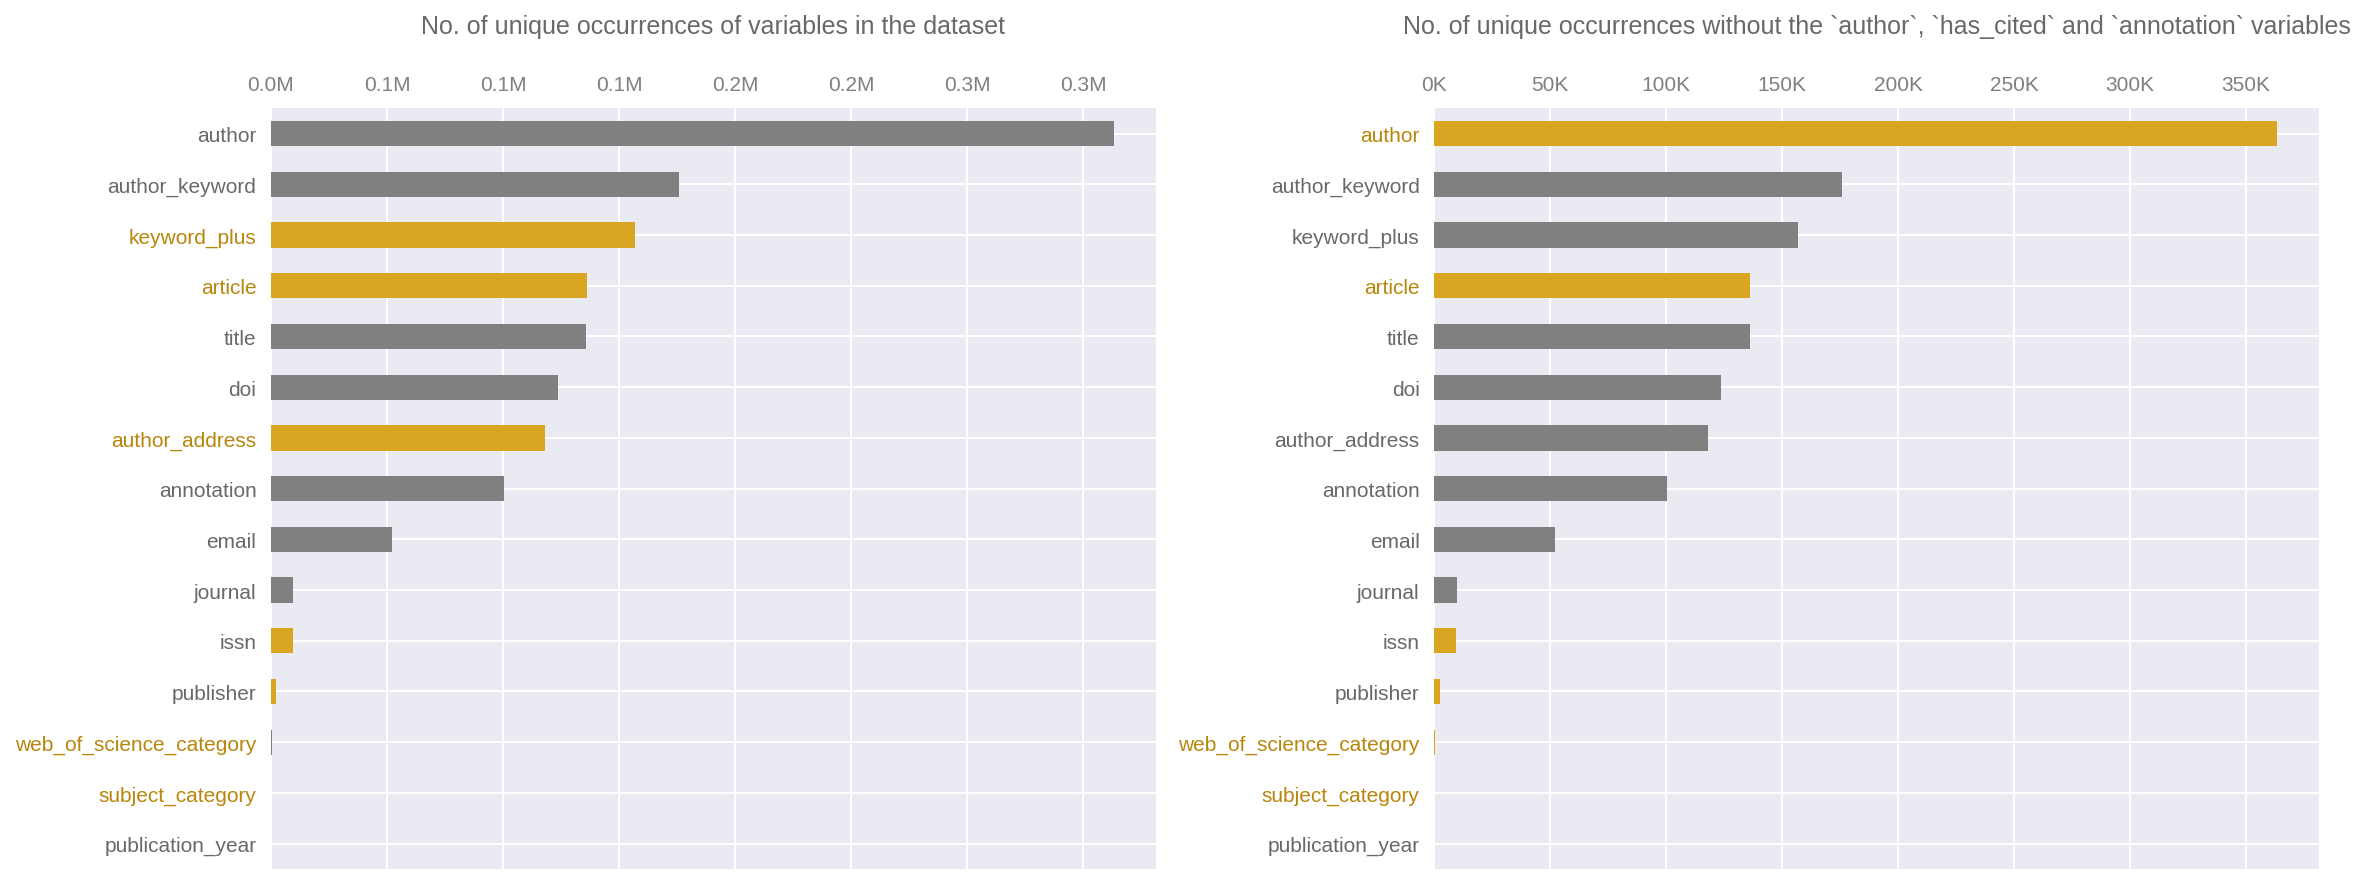

In [513]:
#===== PANEL SETUP =====

fig, (left_ax, right_ax) = plt.subplots(ncols=2, figsize=(16, 6))


#===== PANEL 1 =====

# colors for bars (topic bars are colored differently)
bar_colors = ['gray', 'gray', 'goldenrod', 'goldenrod', 'gray', 'gray', 'goldenrod', 'gray', 'gray', 
              'gray', 'goldenrod', 'goldenrod']

ax1 = unique_occurrence_counts.plot.barh(color=bar_colors, ax=left_ax)

# set title
ax1.set_title('No. of unique occurrences of variables in the dataset', pad=20, color='dimgray')

# reorder y axis from larger to smaller
ax1.invert_yaxis()

# change the default ticks and label color
ax1.tick_params(axis='y', colors='dimgray')
ax1.tick_params(axis='x', colors='grey')

# color topic tick labels on the y-axis
ax1.get_yticklabels()[2].set_color('darkgoldenrod')
ax1.get_yticklabels()[3].set_color('darkgoldenrod') 
ax1.get_yticklabels()[6].set_color('darkgoldenrod') 
ax1.get_yticklabels()[-3].set_color('darkgoldenrod') 
ax1.get_yticklabels()[-2].set_color('darkgoldenrod') 

# color axes lines
ax1.spines['top'].set_color('lightgray')
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')
ax1.spines['right'].set_color('lightgray')

# remove unnecessary axes lines
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


# move ticks to the top for x axis
ax1.xaxis.tick_top()

# represent zeroes with 'M'
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: ("%.1f" % float(x/1000000)) + 'M'))


#===== PANEL 2 =====

# colors for bars (topic bars are colored differently)
bar_colors = ['goldenrod', 'gray', 'gray', 'goldenrod', 'gray', 'gray', 'gray', 'gray', 'gray', 
              'gray', 'goldenrod', 'goldenrod']

# draw the plot
# ax2 = unique_occurrence_counts[3:].plot.barh(color=bar_colors, ax=right_ax)
ax2 = unique_occurrence_counts.plot.barh(color=bar_colors, ax=right_ax)

# set title
ax2.set_title('No. of unique occurrences without the `author`, `has_cited` and `annotation` variables', 
              pad=20, color='dimgray')

# reorder y axis from larger to smaller
ax2.invert_yaxis()

# change the default ticks and label color
ax2.tick_params(axis='y', colors='dimgray')
ax2.tick_params(axis='x', colors='grey')

# color topic tick labels on the y-axis
ax2.get_yticklabels()[0].set_color('darkgoldenrod')
ax2.get_yticklabels()[3].set_color('darkgoldenrod') 
ax2.get_yticklabels()[0].set_color('darkgoldenrod') 
ax2.get_yticklabels()[-3].set_color('darkgoldenrod') 
ax2.get_yticklabels()[-2].set_color('darkgoldenrod') 

# color axes lines
ax2.spines['top'].set_color('lightgray')
ax2.spines['bottom'].set_color('lightgray')
ax2.spines['left'].set_color('lightgray')
ax2.spines['right'].set_color('lightgray')

# remove unnecessary axes lines
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# move ticks to the top for x axis
ax2.xaxis.tick_top()

# represent zeroes with 'M'
ax2.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: ("%.0f" % float(x/1000)) + 'K'))


plt.tight_layout()
plt.show()

In [315]:
# Pandas returns only an axes object. The other objects below must be accessed in others ways.
# e.g., (ax.get_yticklabels()[0].set_color('darkgoldenrod')) or by using `rcParams`

# View all plot parameters
plt.rcParams

from matplotlib import rcParams
#rcParams['axes.titlepad'] = 20 


Plot results with Plotly (obsolete):

In [341]:
unique_occurrence_counts_labels = list(unique_occurrence_counts.keys())
unique_occurrence_counts_values = list(unique_occurrence_counts)

data = [graph_objects.Bar(x=unique_occurrence_counts_labels,
                          y=unique_occurrence_counts_values)]

iplot_online(data, filename='wos_demographics')

##### Plotting Experiment: Cumulative Values

**Plot the results**:

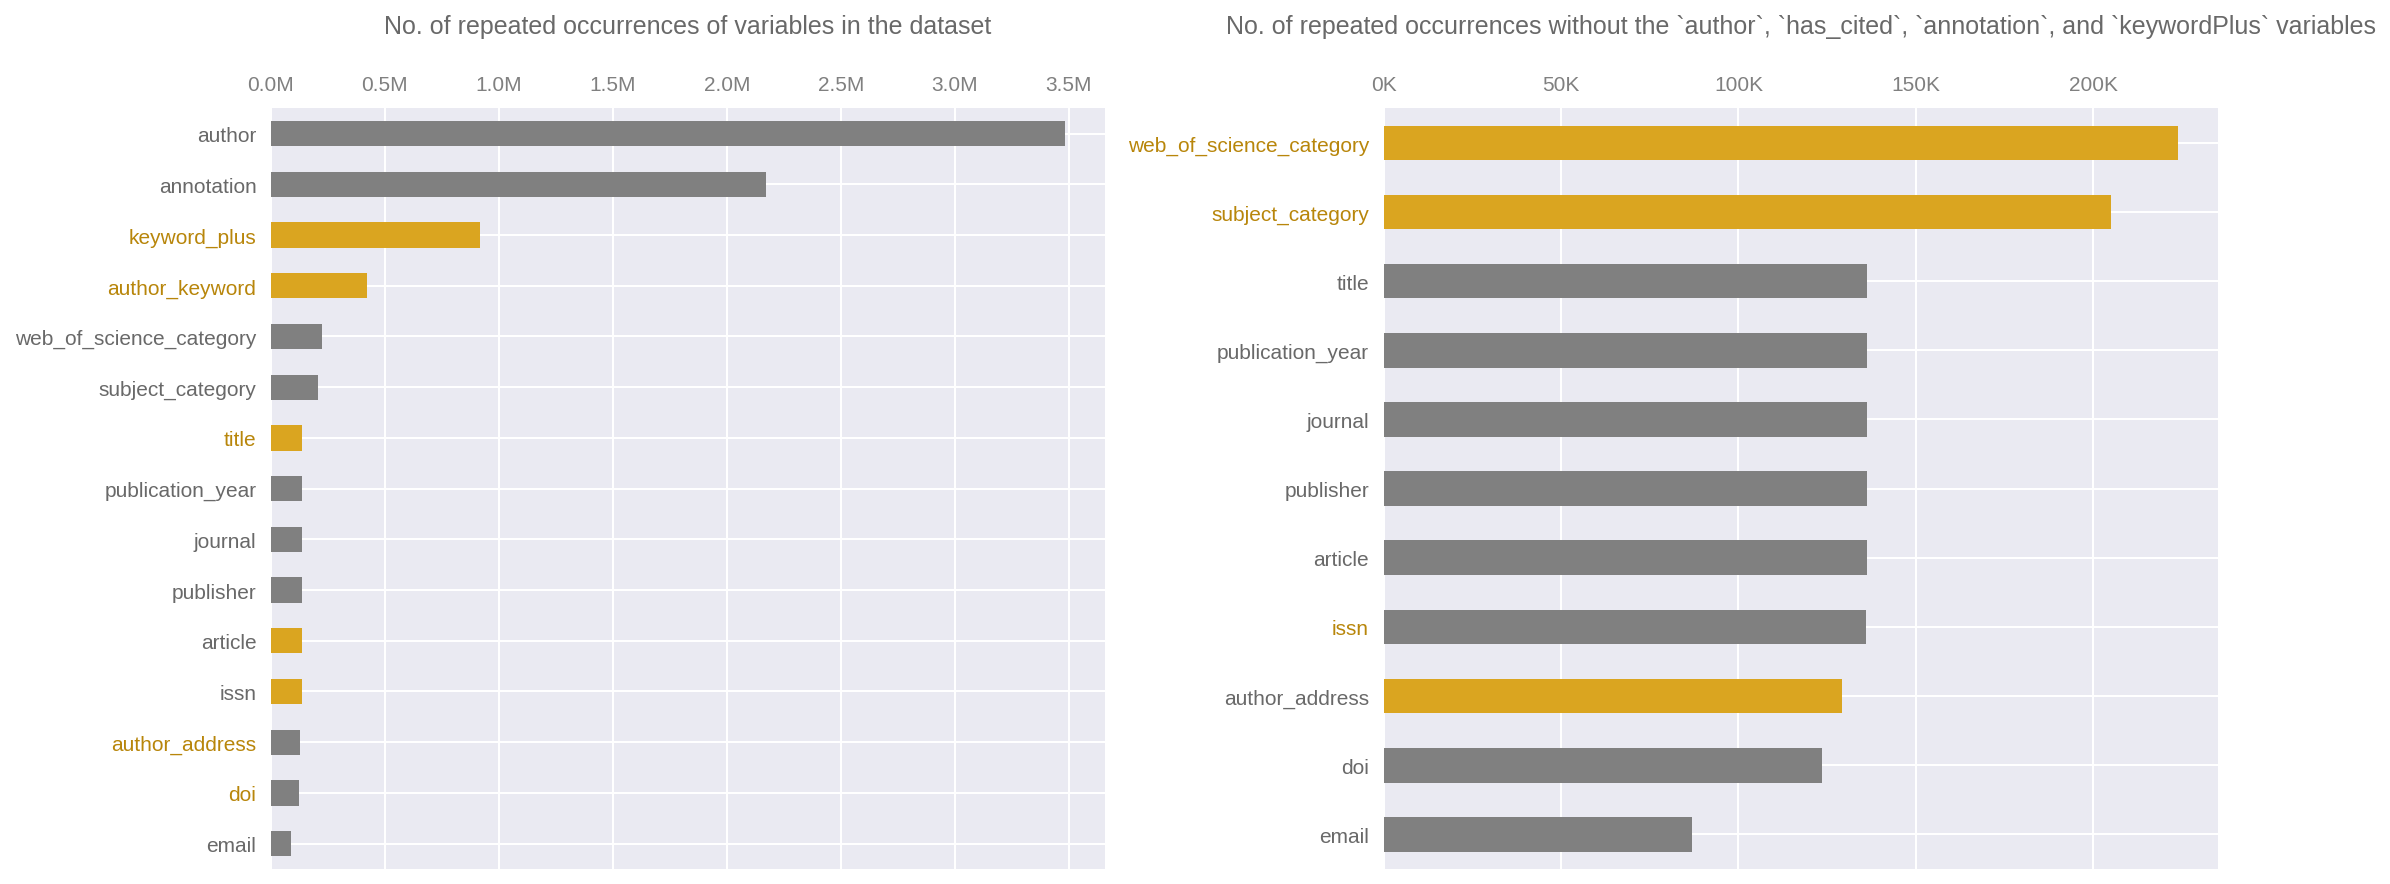

In [512]:
#===== PANEL SETUP =====

fig, (left_ax, right_ax) = plt.subplots(ncols=2, figsize=(16, 6))


#===== PANEL 1 =====

# colors for bars (topic bars are colored differently)
bar_colors = ['gray', 'gray', 'goldenrod', 'goldenrod', 'gray', 'gray', 'goldenrod', 'gray', 'gray', 
              'gray', 'goldenrod', 'goldenrod']

ax1 = cumulative_occurrence_counts.plot.barh(color=bar_colors, ax=left_ax)

# set title
ax1.set_title('No. of repeated occurrences of variables in the dataset', pad=20, color='dimgray')

# reorder y axis from larger to smaller
ax1.invert_yaxis()

# change the default ticks and label color
ax1.tick_params(axis='y', colors='dimgray')
ax1.tick_params(axis='x', colors='grey')

# color topic tick labels on the y-axis
ax1.get_yticklabels()[2].set_color('darkgoldenrod')
ax1.get_yticklabels()[3].set_color('darkgoldenrod') 
ax1.get_yticklabels()[6].set_color('darkgoldenrod') 
ax1.get_yticklabels()[-3].set_color('darkgoldenrod') 
ax1.get_yticklabels()[-2].set_color('darkgoldenrod') 

# color axes lines
ax1.spines['top'].set_color('lightgray')
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')
ax1.spines['right'].set_color('lightgray')

# remove unnecessary axes lines
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


# move ticks to the top for x axis
ax1.xaxis.tick_top()

# represent zeroes with 'M'
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: ("%.1f" % float(x/1000000)) + 'M'))


#===== PANEL 2 =====

# colors for bars (topic bars are colored differently)
bar_colors = ['goldenrod', 'goldenrod', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'goldenrod', 
              'gray', 'gray', 'gray']

# draw the plot
ax2 = cumulative_occurrence_counts[4:].plot.barh(color=bar_colors, ax=right_ax)

# set title
ax2.set_title('No. of repeated occurrences without the `author`, `has_cited`, `annotation`, and `keywordPlus` variables', 
              pad=20, color='dimgray')

# reorder y axis from larger to smaller
ax2.invert_yaxis()

# change the default ticks and label color
ax2.tick_params(axis='y', colors='dimgray')
ax2.tick_params(axis='x', colors='grey')

# color topic tick labels on the y-axis
ax2.get_yticklabels()[0].set_color('darkgoldenrod')
ax2.get_yticklabels()[1].set_color('darkgoldenrod') 
ax2.get_yticklabels()[-4].set_color('darkgoldenrod') 

# color axes lines
ax2.spines['top'].set_color('lightgray')
ax2.spines['bottom'].set_color('lightgray')
ax2.spines['left'].set_color('lightgray')
ax2.spines['right'].set_color('lightgray')

# remove unnecessary axes lines
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# move ticks to the top for x axis
ax2.xaxis.tick_top()

# represent zeroes with 'M'
ax2.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: ("%.0f" % float(x/1000)) + 'K'))


plt.tight_layout()
plt.show()

In [338]:
# Pandas returns only an axes object. The other objects below must be accessed in others ways.
# e.g., (ax.get_yticklabels()[0].set_color('darkgoldenrod')) or by using `rcParams`

# View all plot parameters
import matplotlib.pyplot as plt
plt.rcParams

from matplotlib import rcParams
#rcParams['axes.titlepad'] = 20 


## Older Experiments

In [41]:
list_1 = ['b', 'a &']

list_2 = ["Biochemical Research Methods", "Biotechnology & Applied Microbiology",
          "Computational Biology", "Statistics & Probability",
          "Computer Science", "Interdisciplinary Applications", "Mathematical &"] 

wos_categories_lists = [
    ["Acoustics"], ["Agricultural Economics & Policy"], ["Agricultural Engineering"], ["Agriculture, Dairy & Animal Science"], 
    ["Agriculture, Multidisciplinary"], ["Agronomy"], ["Allergy"], ["Anatomy & Morphology"], ["Andrology"], ["Anesthesiology"], 
    ["Anthropology"], ["Archaeology"], ["Architecture"], ["Area Studies"], ["Art"], ["Asian Studies"], ["Astronomy & Astrophysics"], 
    ["Audiology & Speech-Language Pathology"], ["Automation & Control Systems"], ["Behavioral Sciences"], ["Biochemical Research Methods"], 
    ["Biochemistry & Molecular Biology"], ["Biodiversity Conservation"], ["Biology"], ["Biophysics"], ["Biotechnology & Applied Microbiology"], 
    ["Business"], ["Business, Finance"], ["Cardiac & Cardiovascular Systems"], ["Cell & Tissue Engineering"], ["Cell Biology"], 
    ["Chemistry, Analytical"], ["Chemistry, Applied"], ["Chemistry, Inorganic & Nuclear"], ["Chemistry, Medicinal"], 
    ["Chemistry, Multidisciplinary"], ["Chemistry, Organic"], ["Chemistry, Physical"], ["Classics"], ["Clinical Neurology"], 
    ["Communication"], ["Computer Science, Artificial Intelligence"], ["Computer Science, Cybernetics"], 
    ["Computer Science, Hardware & Architecture"], ["Computer Science, Information Systems"], ["Computer Science, Interdisciplinary Applications"], 
    ["Computer Science, Software Engineering"], ["Computer Science, Theory & Methods"], ["Construction & Building Technology"], 
    ["Criminology & Penology"], ["Critical Care Medicine"], ["Crystallography"], ["Cultural Studies"], ["Dance"], ["Demography"], 
    ["Dentistry, Oral Surgery & Medicine"], ["Dermatology"], ["Developmental Biology"], ["Ecology"], ["Economics"], 
    ["Education & Educational Research"], ["Education, Scientific Disciplines"], ["Education, Special"], ["Electrochemistry"], 
    ["Emergency Medicine"], ["Endocrinology & Metabolism"], ["Energy & Fuels"], ["Engineering, Aerospace"], ["Engineering, Biomedical"], 
    ["Engineering, Chemical"], ["Engineering, Civil"], ["Engineering, Electrical & Electronic"], ["Engineering, Environmental"], 
    ["Engineering, Geological"], ["Engineering, Industrial"], ["Engineering, Manufacturing"], ["Engineering, Marine"], 
    ["Engineering, Mechanical"], ["Engineering, Multidisciplinary"], ["Engineering, Ocean"], ["Engineering, Petroleum"], ["Entomology"], 
    ["Environmental Sciences"], ["Environmental Studies"], ["Ergonomics"], ["Ethics"], ["Ethnic Studies"], ["Evolutionary Biology"], 
    ["Family Studies"], ["Film, Radio, Television"], ["Fisheries"], ["Folklore"], ["Food Science & Technology"], ["Forestry"], 
    ["Gastroenterology & Hepatology"], ["Genetics & Heredity"], ["Geochemistry & Geophysics"], ["Geography"], ["Geography, Physical"], 
    ["Geology"], ["Geosciences, Multidisciplinary"], ["Geriatrics & Gerontology"], ["Gerontology"], ["Green & Sustainable Science & Technology"], 
    ["Health Care Sciences & Services"], ["Health Policy & Services"], ["Hematology"], ["History"], ["History & Philosophy of Science"], 
    ["History of Social Sciences"], ["Horticulture"], ["Hospitality, Leisure, Sport & Tourism"], ["Humanities, Multidisciplinary"], 
    ["Imaging Science & Photographic Technology"], ["Immunology"], ["Industrial Relations & Labor"], ["Infectious Diseases"], 
    ["Information Science & Library Science"], ["Instruments & Instrumentation"], ["Integrative & Complementary Medicine"], 
    ["International Relations"], ["Language & Linguistics"], ["Law"], ["Limnology"], ["Linguistics"], ["Literary Reviews"], 
    ["Literary Theory & Criticism"], ["Literature"], ["Literature, African, Australian, Canadian"], ["Literature, American"], 
    ["Literature, British Isles"], ["Literature, German, Dutch, Scandinavian"], ["Literature, Romance"], ["Literature, Slavic"], 
    ["Logic"], ["Management"], ["Marine & Freshwater Biology"], ["Materials Science, Biomaterials"], ["Materials Science, Ceramics"], 
    ["Materials Science, Characterization & Testing"], ["Materials Science, Coatings & Films"], ["Materials Science, Composites"], 
    ["Materials Science, Multidisciplinary"], ["Materials Science, Paper & Wood"], ["Materials Science, Textiles"], 
    ["Mathematical & Computational Biology"], ["Mathematics"], ["Mathematics, Applied"], ["Mathematics, Interdisciplinary Applications"], 
    ["Mechanics"], ["Medical Ethics"], ["Medical Informatics"], ["Medical Laboratory Technology"], ["Medicine, General & Internal"], 
    ["Medicine, Legal"], ["Medicine, Research & Experimental"], ["Medieval & Renaissance Studies"], ["Metallurgy & Metallurgical Engineering"], 
    ["Meteorology & Atmospheric Sciences"], ["Microbiology"], ["Microscopy"], ["Mineralogy"], ["Mining & Mineral Processing"], 
    ["Multidisciplinary Sciences"], ["Music"], ["Mycology"], ["Nanoscience & Nanotechnology"], ["Neuroimaging"], ["Neurosciences"], 
    ["Nuclear Science & Technology"], ["Nursing"], ["Nutrition & Dietetics"], ["Obstetrics & Gynecology"], ["Oceanography"], ["Oncology"], 
    ["Operations Research & Management Science"], ["Ophthalmology"], ["Optics"], ["Ornithology"], ["Orthopedics"], ["Otorhinolaryngology"], 
    ["Paleontology"], ["Parasitology"], ["Pathology"], ["Pediatrics"], ["Peripheral Vascular Disease"], ["Pharmacology & Pharmacy"], 
    ["Philosophy"], ["Physics, Applied"], ["Physics, Atomic, Molecular & Chemical"], ["Physics, Condensed Matter"], ["Physics, Fluids & Plasmas"], 
    ["Physics, Mathematical"], ["Physics, Multidisciplinary"], ["Physics, Nuclear"], ["Physics, Particles & Fields"], ["Physiology"], 
    ["Planning & Development"], ["Plant Sciences"], ["Poetry"], ["Political Science"], ["Polymer Science"], ["Primary Health Care"], 
    ["Psychiatry"], ["Psychology"], ["Psychology, Applied"], ["Psychology, Biological"], ["Psychology, Clinical"], ["Psychology, Developmental"], 
    ["Psychology, Educational"], ["Psychology, Experimental"], ["Psychology, Mathematical"], ["Psychology, Multidisciplinary"], 
    ["Psychology, Psychoanalysis"], ["Psychology, Social"], ["Public Administration"], ["Public, Environmental & Occupational Health"], 
    ["Radiology, Nuclear Medicine & Medical Imaging"], ["Rehabilitation"], ["Religion"], ["Remote Sensing"], ["Reproductive Biology"], 
    ["Respiratory System"], ["Rheumatology"], ["Robotics"], ["Social Issues"], ["Social Sciences, Biomedical"], ["Social Sciences, Interdisciplinary"], 
    ["Social Sciences, Mathematical Methods"], ["Social Work"], ["Sociology"], ["Soil Science"], ["Spectroscopy"], ["Sport Sciences"], 
    ["Statistics & Probability"], ["Substance Abuse"], ["Surgery"], ["Telecommunications"], ["Theater"], ["Thermodynamics"], ["Toxicology"], 
    ["Transplantation"], ["Transportation"], ["Transportation Science & Technology"], ["Tropical Medicine"], ["Urban Studies"], 
    ["Urology & Nephrology"], ["Veterinary Sciences"], ["Virology"], ["Water Resources"], ["Women's Studies"], ["Zoology"]
]

In [42]:
list_2

['Biochemical Research Methods',
 'Biotechnology & Applied Microbiology',
 'Computational Biology',
 'Statistics & Probability',
 'Computer Science',
 'Interdisciplinary Applications',
 'Mathematical &']

In [43]:
wos_categories_list = ['Mathematical & Computational Biology']
input_list = list_2



for i, each_item in enumerate(input_list):
    # if an item ends with '&' 
    if '&' == each_item[-1]:
        
        string_part_one = input_list.pop(i)
        
        indices_of_possible_part_twos = []
        for i, each_remaining_item in enumerate(input_list):
            
            each_possible_combination = string_part_one + ' ' + each_remaining_item
            
            if each_possible_combination in wos_categories_list:    
                indices_of_possible_part_twos.append(i)

        # if there is only one possible match
        if len(indices_of_possible_part_twos) > 1:
            raise Exception ("Hmm")

        elif len(indices_of_possible_part_twos) == 1:

            index_of_part_two = indices_of_possible_part_twos[0]
            string_part_two = input_list.pop(index_of_part_two)

            combined_string = string_part_one + ' ' + string_part_two
            input_list.append(combined_string)

        # if no possible match within the comparison list is found
        else:
            pass                
            
    # if no item ends with '&'    
    else:
        pass

In [44]:
list_2

['Biochemical Research Methods',
 'Biotechnology & Applied Microbiology',
 'Statistics & Probability',
 'Computer Science',
 'Interdisciplinary Applications',
 'Mathematical & Computational Biology']

In [23]:
"""

                SELECT (COUNT (?literal) AS ?literals) 
                WHERE{
                    GRAPH %(graph)s {
                        ?%(subject)s a wos:Article;
                                 %(property)s ?literal .
                    }
                }
            """ % {'graph':'a:', 'subject':'a', 'property':'a'}

'\n\n                SELECT (COUNT (?literal) AS ?literals) \n                WHERE{\n                    GRAPH a: {\n                        ?a a wos:Article;\n                                 a ?literal .\n                    }\n                }\n            '